In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

In [ ]:
import sys
sys.path.append('./coeqwalpackage')

from coeqwalpackage.metrics import *
import cqwlutils as cu
import plotting as pu

In [ ]:
pu.enable_headless_mode()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

## Define contol file name

In [3]:
CtrlFile = 'CalSim3DataExtractionInitFile_v4.xlsx'
CtrlTab = 'Init'

## Notebook configuration


In [ ]:
BASELINE_ID = "s0020"
HIGHLIGHT_SCENARIOS = [10, 11, 20, 21, 23, 24]
DPI = 300


## Read from control file

In [4]:
ScenarioListFile, ScenarioListTab, ScenarioListPath, DVDssNamesOutPath, SVDssNamesOutPath, ScenarioIndicesOutPath, DssDirsOutPath, VarListPath, VarListFile, VarListTab, VarOutPath, DataOutPath, ConvertDataOutPath, ExtractionSubPath, DemandDeliverySubPath, ModelSubPath, GroupDataDirPath, ScenarioDir, DVDssMin, DVDssMax, SVDssMin, SVDssMax, NameMin, NameMax, DirMin, DirMax, IndexMin, IndexMax, StartMin, StartMax, EndMin, EndMax, VarMin, VarMax, DemandFilePath, DemandFileName, DemandFileTab, DemMin, DemMax, InflowOutSubPath, InflowFilePath, InflowFileName, InflowFileTab, InflowMin, InflowMax = cu.read_init_file(CtrlFile, CtrlTab)

### Read in Data

In [ ]:
df, dss_names = read_in_df(ConvertDataOutPath,DVDssNamesOutPath)
df = add_water_year_column(df)


In [ ]:
print(f"Loaded data frame shape: {df.shape}")
print(f"Total scenarios: {len(dss_names)}")


In [ ]:
scenario_names = cu.build_scenario_labels_from_listing(ScenarioListPath, ScenarioListFile, ScenarioListTab)
scenario_label_lookup = {f"s{sid:04d}": label for sid, label in scenario_names.items()}
highlight_ids = []
for item in HIGHLIGHT_SCENARIOS:
    if isinstance(item, str) and item.lower().startswith('s'):
        highlight_ids.append(item.lower())
    else:
        highlight_ids.append(f"s{int(item):04d}")
highlight_ids = [hid.lower() for hid in highlight_ids]
color_pool = [to_hex(c) for c in (plt.cm.tab10.colors + plt.cm.Set2.colors + plt.cm.Dark2.colors)]
highlight_colors = []
color_idx = 0
for hid in highlight_ids:
    if hid == BASELINE_ID.lower():
        highlight_colors.append('#000000')
    else:
        highlight_colors.append(color_pool[color_idx % len(color_pool)])
        color_idx += 1
highlight_labels = [scenario_label_lookup.get(hid.upper(), hid.upper()) for hid in highlight_ids]
highlight_config = list(zip(highlight_ids, highlight_colors, highlight_labels))
baseline_label_text = scenario_label_lookup.get(BASELINE_ID.upper(), BASELINE_ID)


### Get metrics paths and make directories if needed

In [7]:
metrics_root = Path(GroupDataDirPath) / "metrics_output"
metrics_root.mkdir(parents=True, exist_ok=True)
plots_dir = metrics_root / "parallel_plots"
plots_dir.mkdir(parents=True, exist_ok=True)


## Metrics Examples

In [8]:
# To get a single metric and variable dataframe, type metrics[Month_{var}_{metric}] ie metrics['Apr_S_RESTOT_NOD_mnth_avg'], thresholds["S_SHSTA_frequency_hitting_level5"]
# Month = Apr, Sept... or None
# Metric = [ann_avg, mnth_avg, compute_iqr, ann_percentile, moy_avgs, mnth_percentile, annual_totals]

In [9]:
# Variables

# SCENARIOS 6-10 ARE NOT WRITING S_FOLSMLEVEL5DV!
variables_storage = ["S_SHSTA_", "S_OROVL_", "S_TRNTY_", "S_SLUIS_CVP_", "S_SLUIS_SWP_", "S_MLRTN_", "S_MELON_"]
variables_floodpool = ["S_SHSTALEVEL5DV", "S_OROVLLEVEL5DV", "S_TRNTYLEVEL5DV", "S_SLUIS_CVPLEVEL5DV", "S_SLUIS_SWPLEVEL5DV", "S_MLRTN_LEVEL5DV", "S_MELONLEVEL4DV"]
variables_deadpool = ["S_SHSTALEVEL1DV", "S_OROVLLEVEL1DV", "S_TRNTYLEVEL1DV", "S_SLUIS_CVPLEVEL1DV", "S_SLUIS_SWPLEVEL1DV", "S_MLRTN_LEVEL1DV", "S_MELONLEVEL1DV"]
write_out_dfs = []

# substitute constants for missing variables
S_MLRTN_level5constant = 524
S_MLRTN_level1constant = 135
S_MELON_level1constant = 80


In [10]:
thresholds, threshold_outputs = compute_storage_thresholds(
    df,
    dss_names,
    variables_storage,
    variables_deadpool,
    variables_floodpool,
    mlrtn_level5constant=S_MLRTN_level5constant,
    mlrtn_level1constant=S_MLRTN_level1constant,
    smelon_level1constant=S_MELON_level1constant,
)

write_out_dfs.extend(threshold_outputs)

for threshold_key, (threshold_df, threshold_fraction) in thresholds.items():
    threshold_fraction


Variables:
['S_SHSTA_', 'S_OROVL_', 'S_TRNTY_', 'S_SLUIS_CVP_', 'S_SLUIS_SWP_', 'S_MLRTN_', 'S_MELON_']
Current variable: S_SHSTA_
Current variable: S_OROVL_
Current variable: S_TRNTY_
Current variable: S_SLUIS_CVP_
Current variable: S_SLUIS_SWP_
Current variable: S_MLRTN_
Current variable: S_MELON_


All_Prob_S_SHSTA_flood
s0001                0.333333
s0002                0.315000
s0003                0.222500
s0004                0.192500
s0005                0.175833
s0006                0.303333
s0007                0.301667
s0008                0.300833
s0009                0.300833
s0010                0.301667
s0011                0.315833
s0012                0.330000
s0013                0.196667
s0014                0.205833
s0015                0.329167
s0016                0.208333
s0018                0.058333
s0019                0.331667
s0020                0.311667
s0021                0.311667
s0022                0.325833
s0023                0.315000
s0024                0.315000

All_Prob_S_SHSTA_dead
s0001               0.004167
s0002               0.017500
s0003               0.038333
s0004               0.052500
s0005               0.053333
s0006               0.003333
s0007               0.000000
s0008               0.000000
s0009               0.000000
s0010               0.000000
s0011               0.012500
s0012               0.018333
s0013               0.050833
s0014               0.045000
s0015               0.011667
s0016               0.030000
s0018               0.239167
s0019               0.019167
s0020               0.015000
s0021               0.028333
s0022               0.007500
s0023               0.010000
s0024               0.003333

Sept_Prob_S_SHSTA_flood
s0001                     0.31
s0002                     0.33
s0003                     0.17
s0004                     0.13
s0005                     0.13
s0006                     0.32
s0007                     0.32
s0008                     0.32
s0009                     0.32
s0010                     0.32
s0011                     0.33
s0012                     0.35
s0013                     0.13
s0014                     0.15
s0015                     0.34
s0016                     0.15
s0018                     0.02
s0019                     0.36
s0020                     0.33
s0021                     0.33
s0022                     0.38
s0023                     0.34
s0024                     0.34

Sept_Prob_S_SHSTA_dead
s0001                    0.01
s0002                    0.05
s0003                    0.10
s0004                    0.11
s0005                    0.11
s0006                    0.01
s0007                    0.00
s0008                    0.00
s0009                    0.00
s0010                    0.00
s0011                    0.04
s0012                    0.05
s0013                    0.11
s0014                    0.10
s0015                    0.03
s0016                    0.07
s0018                    0.45
s0019                    0.05
s0020                    0.04
s0021                    0.08
s0022                    0.02
s0023                    0.03
s0024                    0.01

All_Prob_S_OROVL_flood
s0001                0.215000
s0002                0.210000
s0003                0.165833
s0004                0.144167
s0005                0.133333
s0006                0.203333
s0007                0.201667
s0008                0.200000
s0009                0.201667
s0010                0.201667
s0011                0.210833
s0012                0.214167
s0013                0.146667
s0014                0.153333
s0015                0.215833
s0016                0.154167
s0018                0.109167
s0019                0.219167
s0020                0.213333
s0021                0.211667
s0022                0.216667
s0023                0.211667
s0024                0.213333

All_Prob_S_OROVL_dead
s0001               0.000000
s0002               0.000833
s0003               0.010000
s0004               0.016667
s0005               0.024167
s0006               0.000000
s0007               0.000000
s0008               0.000000
s0009               0.000000
s0010               0.000000
s0011               0.000833
s0012               0.000833
s0013               0.017500
s0014               0.015833
s0015               0.000000
s0016               0.006667
s0018               0.066667
s0019               0.000000
s0020               0.000833
s0021               0.000833
s0022               0.002500
s0023               0.003333
s0024               0.001667

Sept_Prob_S_OROVL_flood
s0001                     0.05
s0002                     0.09
s0003                     0.01
s0004                     0.01
s0005                     0.01
s0006                     0.07
s0007                     0.06
s0008                     0.06
s0009                     0.06
s0010                     0.06
s0011                     0.09
s0012                     0.10
s0013                     0.01
s0014                     0.01
s0015                     0.10
s0016                     0.01
s0018                     0.02
s0019                     0.09
s0020                     0.08
s0021                     0.08
s0022                     0.08
s0023                     0.07
s0024                     0.07

Sept_Prob_S_OROVL_dead
s0001                    0.00
s0002                    0.00
s0003                    0.02
s0004                    0.04
s0005                    0.06
s0006                    0.00
s0007                    0.00
s0008                    0.00
s0009                    0.00
s0010                    0.00
s0011                    0.00
s0012                    0.00
s0013                    0.03
s0014                    0.03
s0015                    0.00
s0016                    0.02
s0018                    0.11
s0019                    0.00
s0020                    0.00
s0021                    0.00
s0022                    0.00
s0023                    0.01
s0024                    0.00

All_Prob_S_TRNTY_flood
s0001                0.000000
s0002                0.000833
s0003                0.000000
s0004                0.000000
s0005                0.000000
s0006                0.000000
s0007                0.000000
s0008                0.000000
s0009                0.000000
s0010                0.000000
s0011                0.000833
s0012                0.000833
s0013                0.000000
s0014                0.000000
s0015                0.000833
s0016                0.000000
s0018                0.000833
s0019                0.000833
s0020                0.000833
s0021                0.000833
s0022                0.000833
s0023                0.000833
s0024                0.000833

All_Prob_S_TRNTY_dead
s0001               0.000000
s0002               0.000000
s0003               0.000000
s0004               0.000000
s0005               0.000000
s0006               0.004167
s0007               0.000000
s0008               0.000833
s0009               0.000833
s0010               0.000833
s0011               0.000000
s0012               0.000000
s0013               0.000000
s0014               0.000000
s0015               0.000000
s0016               0.000000
s0018               0.012500
s0019               0.000000
s0020               0.000000
s0021               0.000000
s0022               0.000000
s0023               0.000000
s0024               0.000000

Sept_Prob_S_TRNTY_flood
s0001                      0.0
s0002                      0.0
s0003                      0.0
s0004                      0.0
s0005                      0.0
s0006                      0.0
s0007                      0.0
s0008                      0.0
s0009                      0.0
s0010                      0.0
s0011                      0.0
s0012                      0.0
s0013                      0.0
s0014                      0.0
s0015                      0.0
s0016                      0.0
s0018                      0.0
s0019                      0.0
s0020                      0.0
s0021                      0.0
s0022                      0.0
s0023                      0.0
s0024                      0.0

Sept_Prob_S_TRNTY_dead
s0001                    0.00
s0002                    0.00
s0003                    0.00
s0004                    0.00
s0005                    0.00
s0006                    0.02
s0007                    0.00
s0008                    0.01
s0009                    0.01
s0010                    0.01
s0011                    0.00
s0012                    0.00
s0013                    0.00
s0014                    0.00
s0015                    0.00
s0016                    0.00
s0018                    0.03
s0019                    0.00
s0020                    0.00
s0021                    0.00
s0022                    0.00
s0023                    0.00
s0024                    0.00

All_Prob_S_SLUIS_CVP_flood
s0001                    0.078333
s0002                    0.076667
s0003                    0.055000
s0004                    0.046667
s0005                    0.041667
s0006                    0.085000
s0007                    0.087500
s0008                    0.088333
s0009                    0.090833
s0010                    0.091667
s0011                    0.085833
s0012                    0.100000
s0013                    0.050000
s0014                    0.065833
s0015                    0.110000
s0016                    0.064167
s0018                    0.028333
s0019                    0.100000
s0020                    0.125000
s0021                    0.117500
s0022                    0.075833
s0023                    0.120833
s0024                    0.127500

All_Prob_S_SLUIS_CVP_dead
s0001                   0.015833
s0002                   0.027500
s0003                   0.057500
s0004                   0.085000
s0005                   0.102500
s0006                   0.017500
s0007                   0.015000
s0008                   0.017500
s0009                   0.017500
s0010                   0.017500
s0011                   0.025000
s0012                   0.012500
s0013                   0.078333
s0014                   0.044167
s0015                   0.006667
s0016                   0.040833
s0018                   0.195000
s0019                   0.012500
s0020                   0.025833
s0021                   0.025000
s0022                   0.015833
s0023                   0.025000
s0024                   0.028333

Sept_Prob_S_SLUIS_CVP_flood
s0001                         0.01
s0002                         0.01
s0003                         0.01
s0004                         0.00
s0005                         0.00
s0006                         0.00
s0007                         0.00
s0008                         0.00
s0009                         0.00
s0010                         0.00
s0011                         0.01
s0012                         0.01
s0013                         0.00
s0014                         0.01
s0015                         0.01
s0016                         0.01
s0018                         0.01
s0019                         0.01
s0020                         0.01
s0021                         0.01
s0022                         0.00
s0023                         0.01
s0024                         0.01

Sept_Prob_S_SLUIS_CVP_dead
s0001                        0.05
s0002                        0.08
s0003                        0.13
s0004                        0.21
s0005                        0.22
s0006                        0.00
s0007                        0.00
s0008                        0.00
s0009                        0.00
s0010                        0.00
s0011                        0.07
s0012                        0.03
s0013                        0.20
s0014                        0.13
s0015                        0.00
s0016                        0.09
s0018                        0.44
s0019                        0.04
s0020                        0.04
s0021                        0.05
s0022                        0.04
s0023                        0.06
s0024                        0.07

All_Prob_S_SLUIS_SWP_flood
s0001                    0.065833
s0002                    0.073333
s0003                    0.060000
s0004                    0.051667
s0005                    0.042500
s0006                    0.057500
s0007                    0.160000
s0008                    0.180000
s0009                    0.189167
s0010                    0.190000
s0011                    0.076667
s0012                    0.088333
s0013                    0.055000
s0014                    0.060833
s0015                    0.088333
s0016                    0.063333
s0018                    0.058333
s0019                    0.078333
s0020                    0.085000
s0021                    0.085833
s0022                    0.100000
s0023                    0.114167
s0024                    0.111667

All_Prob_S_SLUIS_SWP_dead
s0001                   0.029167
s0002                   0.026667
s0003                   0.027500
s0004                   0.055833
s0005                   0.043333
s0006                   0.040000
s0007                   0.030833
s0008                   0.033333
s0009                   0.033333
s0010                   0.033333
s0011                   0.025000
s0012                   0.025000
s0013                   0.033333
s0014                   0.025833
s0015                   0.021667
s0016                   0.025833
s0018                   0.035000
s0019                   0.019167
s0020                   0.027500
s0021                   0.030000
s0022                   0.035000
s0023                   0.037500
s0024                   0.043333

Sept_Prob_S_SLUIS_SWP_flood
s0001                         0.00
s0002                         0.00
s0003                         0.00
s0004                         0.00
s0005                         0.00
s0006                         0.00
s0007                         0.01
s0008                         0.01
s0009                         0.01
s0010                         0.01
s0011                         0.00
s0012                         0.00
s0013                         0.00
s0014                         0.00
s0015                         0.00
s0016                         0.00
s0018                         0.00
s0019                         0.00
s0020                         0.00
s0021                         0.00
s0022                         0.02
s0023                         0.02
s0024                         0.02

Sept_Prob_S_SLUIS_SWP_dead
s0001                        0.05
s0002                        0.05
s0003                        0.06
s0004                        0.13
s0005                        0.07
s0006                        0.06
s0007                        0.06
s0008                        0.05
s0009                        0.07
s0010                        0.07
s0011                        0.05
s0012                        0.04
s0013                        0.06
s0014                        0.04
s0015                        0.03
s0016                        0.04
s0018                        0.08
s0019                        0.02
s0020                        0.05
s0021                        0.06
s0022                        0.07
s0023                        0.08
s0024                        0.08

All_Prob_S_MLRTN_flood
s0001                0.023333
s0002                0.024167
s0003                0.027500
s0004                0.028333
s0005                0.027500
s0006                0.042500
s0007                0.042500
s0008                0.042500
s0009                0.042500
s0010                0.042500
s0011                0.024167
s0012                0.024167
s0013                0.030000
s0014                0.029167
s0015                0.024167
s0016                0.029167
s0018                0.020833
s0019                0.024167
s0020                0.023333
s0021                0.023333
s0022                0.045000
s0023                0.044167
s0024                0.044167

Sept_Prob_S_MLRTN_flood
s0001                      0.0
s0002                      0.0
s0003                      0.0
s0004                      0.0
s0005                      0.0
s0006                      0.0
s0007                      0.0
s0008                      0.0
s0009                      0.0
s0010                      0.0
s0011                      0.0
s0012                      0.0
s0013                      0.0
s0014                      0.0
s0015                      0.0
s0016                      0.0
s0018                      0.0
s0019                      0.0
s0020                      0.0
s0021                      0.0
s0022                      0.0
s0023                      0.0
s0024                      0.0

All_Prob_S_MLRTN_dead
s0001               0.025000
s0002               0.022500
s0003               0.028333
s0004               0.035000
s0005               0.047500
s0006               0.026667
s0007               0.026667
s0008               0.026667
s0009               0.026667
s0010               0.026667
s0011               0.022500
s0012               0.011667
s0013               0.036667
s0014               0.013333
s0015               0.011667
s0016               0.013333
s0018               0.042500
s0019               0.014167
s0020               0.041667
s0021               0.041667
s0022               0.174167
s0023               0.217500
s0024               0.218333

Sept_Prob_S_MLRTN_dead
s0001                    0.00
s0002                    0.00
s0003                    0.01
s0004                    0.01
s0005                    0.02
s0006                    0.01
s0007                    0.01
s0008                    0.01
s0009                    0.01
s0010                    0.01
s0011                    0.00
s0012                    0.00
s0013                    0.01
s0014                    0.00
s0015                    0.00
s0016                    0.00
s0018                    0.03
s0019                    0.00
s0020                    0.00
s0021                    0.00
s0022                    0.05
s0023                    0.13
s0024                    0.14

All_Prob_S_MELON_dead
s0001               0.000000
s0002               0.000000
s0003               0.008333
s0004               0.018333
s0005               0.027500
s0006               0.000000
s0007               0.000000
s0008               0.000000
s0009               0.000000
s0010               0.000000
s0011               0.000000
s0012               0.000000
s0013               0.018333
s0014               0.018333
s0015               0.000000
s0016               0.018333
s0018               0.295833
s0019               0.000000
s0020               0.000000
s0021               0.000000
s0022               0.000000
s0023               0.000000
s0024               0.000000

Sept_Prob_S_MELON_dead
s0001                    0.00
s0002                    0.00
s0003                    0.01
s0004                    0.03
s0005                    0.05
s0006                    0.00
s0007                    0.00
s0008                    0.00
s0009                    0.00
s0010                    0.00
s0011                    0.00
s0012                    0.00
s0013                    0.03
s0014                    0.03
s0015                    0.00
s0016                    0.03
s0018                    0.45
s0019                    0.00
s0020                    0.00
s0021                    0.00
s0022                    0.00
s0023                    0.00
s0024                    0.00

In [11]:
# Flow Requirements - only running scenario 18 (dss_names is messing it up, replace ["s0018"] with dss_names later)
# Missing C_SAC000_MIF_s0018

actual_flows = ["C_AMR004_s0018", "C_TRN111_s0018", "C_FTR029_s0018", "C_MOK028_s0018", "C_MCD005_s0018", "C_SAC257_s0018", "C_SJR127_s0018", "C_SAC289_s0018", "C_STS011_s0018",
                 "C_TUO003_s0018", "C_YUB002_s0018", "SP_SAC159_BTC003_s0018", "C_SAC148_s0018", "C_SAC122_s0018", "C_FTR003_s0018", "C_SAC049_s0018", "C_SJR070_s0018"
]
min_flows = ["C_AMR004_MIF_s0018", "C_TRN111_MIF_s0018", "C_FTR029_MIF_s0018", "C_MOK028_MIF_s0018", "C_MCD005_MIF_s0018", "C_SAC257_MIF_s0018", "C_SJR127_MIF_s0018", "C_SAC289_MIF_s0018", "C_STS011_MIF_s0018",
             "C_TUO003_MIF_s0018", "C_YUB002_MIF_s0018", "SP_SAC159_BTC003_MIF_s0018", "C_SAC148_MIF_s0018", "C_SAC122_MIF_s0018", "C_FTR003_MIF_s0018", "C_SAC049_MIF_s0018", "C_SJR070_MIF_s0018"
]


In [12]:
# SKIP FOR THIS METRICS ITERATION
# Uncomment this block when revisiting minimum flow differences.
# (logic intentionally left out to avoid unnecessary runtime)


In [14]:
# Metrics (PDF)

variables = [
    "S_RESTOT_NOD_", "S_RESTOT_s",
    "S_SHSTA_", "S_OROVL_", "S_TRNTY_", "S_FOLSM_", "S_MELON_", "S_MLRTN_","S_SLUIS_SWP", "S_SLUIS_CVP",
    "DEL_SWP_TOTAL_", "DEL_SWP_PMI_", "DEL_SWP_PAG_", "DEL_CVP_TOTAL_", "DEL_CVP_PAG_TOTAL_", "DEL_CVP_PSCEX_TOTAL_", "DEL_CVP_PRF_TOTAL_",
    "D_TOTAL_", "NDO_",
    "X2_PRV_KM_","EM_EC_MONTH_","JP_EC_MONTH",
    "DEL_CVP_PSC_N_", "DEL_CVP_PAG_N_", "DEL_CVP_PAG_S_", "DEL_CVP_PRF_S_", "DEL_CVP_PMI_N_", "DEL_CVP_PMI_S_"
] 

In [15]:
metrics, metric_outputs = compute_metrics_suite(df, dss_names, variables)
write_out_dfs.extend(metric_outputs)

for name, metric_df in metrics.items():
    metric_df


Apr_Avg_S_RESTOT_NOD_TAF
s0001               9502.720622
s0002               9289.524626
s0003               8831.470114
s0004               8536.757009
s0005               8363.576594
s0006               8797.665441
s0007               8818.561157
s0008               8817.579762
s0009               8806.576365
s0010               8809.165562
s0011               9353.654643
s0012               9331.701300
s0013               8564.764796
s0014               8652.462178
s0015               9385.572308
s0016               8764.127927
s0018               6283.530278
s0019               9346.129111
s0020               9307.876442
s0021               9240.173084
s0022               9378.687942
s0023               9300.553889
s0024               9363.643727

Sep_Avg_S_RESTOT_NOD_TAF
s0001               6800.449020
s0002               6570.594230
s0003               5655.789429
s0004               5292.440964
s0005               5134.175172
s0006               6152.457555
s0007               6193.778243
s0008               6194.621633
s0009               6187.818817
s0010               6188.742741
s0011               6637.061312
s0012               6673.551830
s0013               5363.289898
s0014               5499.450178
s0015               6726.838606
s0016               5583.838193
s0018               3695.835463
s0019               6705.334035
s0020               6578.018614
s0021               6516.743957
s0022               6706.649021
s0023               6616.810060
s0024               6683.030797

Ann_Avg_S_RESTOT_NOD_TAF
s0001               7853.169431
s0002               7623.606132
s0003               6950.481933
s0004               6632.544663
s0005               6466.611887
s0006               7197.412860
s0007               7226.445065
s0008               7225.273167
s0009               7215.806359
s0010               7218.224010
s0011               7687.670777
s0012               7694.020865
s0013               6684.533450
s0014               6791.204920
s0015               7746.689301
s0016               6871.857279
s0018               4694.612314
s0019               7719.523202
s0020               7632.575712
s0021               7572.374062
s0022               7750.665463
s0023               7659.423684
s0024               7720.697092

Apr_Avg_S_RESTOT_sTAF
s0001           11511.439131
s0002           11303.156554
s0003           10903.099940
s0004           10550.181127
s0005           10321.439679
s0006           10641.042921
s0007           10662.103601
s0008           10661.234972
s0009           10650.272755
s0010           10652.850867
s0011           11369.958607
s0012           11361.871955
s0013           10575.017786
s0014           10679.036953
s0015           11415.657065
s0016           10790.703118
s0018            7163.486314
s0019           11373.816948
s0020           11328.821029
s0021           11261.157868
s0022           11462.499682
s0023           11374.712983
s0024           11443.740068

Sep_Avg_S_RESTOT_sTAF
s0001            8537.728392
s0002            8283.957292
s0003            7223.204372
s0004            6785.620518
s0005            6569.599413
s0006            7733.253688
s0007            7774.708571
s0008            7775.646336
s0009            7768.880840
s0010            7769.795451
s0011            8350.223470
s0012            8396.879142
s0013            6852.163125
s0014            7003.375724
s0015            8450.013468
s0016            7087.765045
s0018            4327.925074
s0019            8426.471002
s0020            8306.166528
s0021            8244.927510
s0022            8550.639835
s0023            8456.950484
s0024            8530.566500

Ann_Avg_S_RESTOT_sTAF
s0001            9770.454006
s0002            9521.421130
s0003            8760.381595
s0004            8370.589893
s0005            8145.127060
s0006            8942.803068
s0007            8971.983656
s0008            8970.913313
s0009            8961.482988
s0010            8963.890612
s0011            9585.476906
s0012            9603.386566
s0013            8418.472804
s0014            8540.512334
s0015            9655.924557
s0016            8621.167390
s0018            5468.791806
s0019            9626.684147
s0020            9541.666334
s0021            9481.506234
s0022            9760.971060
s0023            9665.432466
s0024            9733.480043

Apr_Avg_S_SHSTA_TAF
s0001          4037.991051
s0002          3920.254867
s0003          3711.537404
s0004          3592.096895
s0005          3511.278046
s0006          4035.944251
s0007          4044.659226
s0008          4044.682619
s0009          4038.165765
s0010          4038.121174
s0011          3947.517963
s0012          3936.999494
s0013          3604.374799
s0014          3647.361582
s0015          3959.618993
s0016          3703.121111
s0018          2585.118500
s0019          3925.323726
s0020          3906.981872
s0021          3865.966070
s0022          3976.205349
s0023          3937.173320
s0024          3952.434048

Sep_Avg_S_SHSTA_TAF
s0001          2876.659464
s0002          2747.480814
s0003          2404.538660
s0004          2239.528707
s0005          2164.107557
s0006          2826.722706
s0007          2845.698972
s0008          2843.500124
s0009          2837.774927
s0010          2836.920539
s0011          2768.978717
s0012          2796.612883
s0013          2278.810506
s0014          2353.902302
s0015          2811.251218
s0016          2381.217053
s0018          1268.260729
s0019          2780.768756
s0020          2703.766192
s0021          2676.155042
s0022          2830.112505
s0023          2784.121980
s0024          2802.383980

AprS_SHSTA__CV
s0001        0.164362
s0002        0.196397
s0003        0.241658
s0004        0.267786
s0005        0.281576
s0006        0.170699
s0007        0.164044
s0008        0.164287
s0009        0.167213
s0010        0.167039
s0011        0.180249
s0012        0.191947
s0013        0.267291
s0014        0.255166
s0015        0.177481
s0016        0.226201
s0018        0.481953
s0019        0.197127
s0020        0.190939
s0021        0.214516
s0022        0.171776
s0023        0.182122
s0024        0.177071

SeptS_SHSTA__CV
s0001         0.239686
s0002         0.289071
s0003         0.371235
s0004         0.406971
s0005         0.421263
s0006         0.254046
s0007         0.246494
s0008         0.247206
s0009         0.250697
s0010         0.250419
s0011         0.274274
s0012         0.276587
s0013         0.398569
s0014         0.383898
s0015         0.266487
s0016         0.370395
s0018         0.713811
s0019         0.294214
s0020         0.304486
s0021         0.324285
s0022         0.256564
s0023         0.274155
s0024         0.258242

Apr_Avg_S_OROVL_TAF
s0001          2769.478097
s0002          2725.012594
s0003          2550.107122
s0004          2453.495348
s0005          2406.063563
s0006          2900.849137
s0007          2909.776964
s0008          2907.110805
s0009          2905.539647
s0010          2907.723227
s0011          2750.521664
s0012          2740.577751
s0013          2453.422592
s0014          2477.824818
s0015          2762.328846
s0016          2514.576337
s0018          2026.087754
s0019          2768.758525
s0020          2761.209657
s0021          2744.009972
s0022          2740.701923
s0023          2717.418165
s0024          2742.867562

Sep_Avg_S_OROVL_TAF
s0001          1896.007109
s0002          1859.998103
s0003          1525.877308
s0004          1413.607718
s0005          1371.511661
s0006          1964.104093
s0007          1978.726760
s0008          1979.745469
s0009          1980.648138
s0010          1982.669589
s0011          1885.582822
s0012          1888.510756
s0013          1430.321268
s0014          1455.286247
s0015          1909.645381
s0016          1491.734035
s0018          1270.147638
s0019          1942.305741
s0020          1917.855196
s0021          1898.317381
s0022          1866.751174
s0023          1837.231737
s0024          1864.644421

AprS_OROVL__CV
s0001        0.212192
s0002        0.230273
s0003        0.289735
s0004        0.326807
s0005        0.348947
s0006        0.198016
s0007        0.195524
s0008        0.196964
s0009        0.198006
s0010        0.197361
s0011        0.214510
s0012        0.224569
s0013        0.328020
s0014        0.320394
s0015        0.213120
s0016        0.295904
s0018        0.521701
s0019        0.213603
s0020        0.212354
s0021        0.220674
s0022        0.227645
s0023        0.237246
s0024        0.222322

SeptS_OROVL__CV
s0001         0.356666
s0002         0.403519
s0003         0.442940
s0004         0.485067
s0005         0.510607
s0006         0.348154
s0007         0.342545
s0008         0.343577
s0009         0.344532
s0010         0.343475
s0011         0.378927
s0012         0.397487
s0013         0.483080
s0014         0.476777
s0015         0.378218
s0016         0.435418
s0018         0.698111
s0019         0.346683
s0020         0.343391
s0021         0.361070
s0022         0.392867
s0023         0.408060
s0024         0.380372

Apr_Avg_S_TRNTY_TAF
s0001          1893.161886
s0002          1852.860295
s0003          1816.301950
s0004          1757.846829
s0005          1721.975669
s0006          1872.952548
s0007          1877.675496
s0008          1879.427062
s0009          1876.599830
s0010          1876.848133
s0011          1858.160858
s0012          1858.203079
s0013          1764.425222
s0014          1778.737490
s0015          1863.861067
s0016          1789.848455
s0018          1175.513339
s0019          1857.824409
s0020          1841.918109
s0021          1841.556302
s0022          1872.253567
s0023          1859.493422
s0024          1865.126330

Sep_Avg_S_TRNTY_TAF
s0001          1446.062843
s0002          1401.881668
s0003          1244.946886
s0004          1181.498558
s0005          1149.997502
s0006          1438.270067
s0007          1443.037567
s0008          1444.901597
s0009          1442.825469
s0010          1443.252174
s0011          1409.301033
s0012          1413.873726
s0013          1188.864263
s0014          1208.841328
s0015          1419.832580
s0016          1220.752380
s0018           893.525372
s0019          1410.037039
s0020          1393.307936
s0021          1391.829979
s0022          1450.036296
s0023          1435.640187
s0024          1442.389805

AprS_TRNTY__CV
s0001        0.215741
s0002        0.239156
s0003        0.275506
s0004        0.298745
s0005        0.307092
s0006        0.247619
s0007        0.241925
s0008        0.241773
s0009        0.243873
s0010        0.243950
s0011        0.236715
s0012        0.237227
s0013        0.296890
s0014        0.288833
s0015        0.233302
s0016        0.279777
s0018        0.412212
s0019        0.239921
s0020        0.245553
s0021        0.244558
s0022        0.235827
s0023        0.244277
s0024        0.238815

SeptS_TRNTY__CV
s0001         0.299024
s0002         0.329655
s0003         0.366579
s0004         0.395690
s0005         0.401068
s0006         0.336151
s0007         0.330454
s0008         0.330042
s0009         0.332210
s0010         0.332321
s0011         0.324533
s0012         0.327255
s0013         0.394801
s0014         0.380496
s0015         0.320553
s0016         0.366236
s0018         0.469965
s0019         0.332392
s0020         0.338547
s0021         0.337723
s0022         0.323294
s0023         0.330309
s0024         0.323579

Apr_Avg_S_FOLSM_TAF
s0001           802.089567
s0002           791.396907
s0003           753.523642
s0004           733.317963
s0005           724.259364
s0006           779.600248
s0007           779.464052
s0008           779.311224
s0009           778.520733
s0010           778.887866
s0011           797.454240
s0012           795.920990
s0013           742.542102
s0014           748.538294
s0015           799.763401
s0016           756.581970
s0018           496.810701
s0019           794.222405
s0020           797.766776
s0021           788.640691
s0022           789.527156
s0023           786.468953
s0024           803.215820

Sep_Avg_S_FOLSM_TAF
s0001           581.719592
s0002           561.233654
s0003           480.426600
s0004           457.806009
s0005           448.558460
s0006           546.198396
s0007           551.790172
s0008           552.003526
s0009           551.665109
s0010           551.054226
s0011           573.198679
s0012           574.554451
s0013           465.293837
s0014           481.420278
s0015           586.109444
s0016           490.134712
s0018           263.901753
s0019           572.222464
s0020           563.089224
s0021           550.441556
s0022           559.749047
s0023           559.816103
s0024           573.612562

AprS_FOLSM__CV
s0001        0.179558
s0002        0.198544
s0003        0.257935
s0004        0.287553
s0005        0.297249
s0006        0.229156
s0007        0.228324
s0008        0.228830
s0009        0.230351
s0010        0.229074
s0011        0.184395
s0012        0.189056
s0013        0.271375
s0014        0.259379
s0015        0.180430
s0016        0.242303
s0018        0.707829
s0019        0.192322
s0020        0.182846
s0021        0.203012
s0022        0.195085
s0023        0.199256
s0024        0.163010

SeptS_FOLSM__CV
s0001         0.258190
s0002         0.313035
s0003         0.405338
s0004         0.425055
s0005         0.433445
s0006         0.327483
s0007         0.324805
s0008         0.326064
s0009         0.328546
s0010         0.326821
s0011         0.271620
s0012         0.302576
s0013         0.415063
s0014         0.401765
s0015         0.258294
s0016         0.377906
s0018         0.764997
s0019         0.313422
s0020         0.311941
s0021         0.351643
s0022         0.312550
s0023         0.332549
s0024         0.295491

Apr_Avg_S_MELON_TAF
s0001          1703.984501
s0002          1699.222215
s0003          1669.212691
s0004          1609.003619
s0005          1555.875276
s0006          1749.082000
s0007          1749.084819
s0008          1749.087679
s0009          1749.088577
s0010          1749.087740
s0011          1699.992565
s0012          1700.504533
s0013          1606.533685
s0014          1608.180826
s0015          1700.429975
s0016          1608.182091
s0018           587.667865
s0019          1699.236284
s0020          1715.478699
s0021          1715.478946
s0022          1843.510838
s0023          1840.722301
s0024          1846.689077

Sep_Avg_S_MELON_TAF
s0001          1506.118639
s0002          1484.489717
s0003          1374.427244
s0004          1307.354278
s0005          1253.638177
s0006          1568.194600
s0007          1568.199106
s0008          1568.202827
s0009          1568.204020
s0010          1568.203058
s0011          1485.433202
s0012          1486.102004
s0013          1304.037176
s0014          1306.036861
s0015          1485.953479
s0016          1306.035769
s0018           426.544056
s0019          1484.503994
s0020          1509.215845
s0021          1509.216215
s0022          1654.873726
s0023          1658.889179
s0024          1666.321673

AprS_MELON__CV
s0001        0.228007
s0002        0.252658
s0003        0.288925
s0004        0.321842
s0005        0.347511
s0006        0.209093
s0007        0.209091
s0008        0.209090
s0009        0.209089
s0010        0.209090
s0011        0.253146
s0012        0.252926
s0013        0.322684
s0014        0.321513
s0015        0.252915
s0016        0.321513
s0018        0.896085
s0019        0.252657
s0020        0.246652
s0021        0.246652
s0022        0.193535
s0023        0.193784
s0024        0.193117

SeptS_MELON__CV
s0001         0.275559
s0002         0.305549
s0003         0.357833
s0004         0.394182
s0005         0.425432
s0006         0.248252
s0007         0.248251
s0008         0.248249
s0009         0.248249
s0010         0.248249
s0011         0.306146
s0012         0.305836
s0013         0.395128
s0014         0.393237
s0015         0.305836
s0016         0.393235
s0018         1.139873
s0019         0.305544
s0020         0.296716
s0021         0.296716
s0022         0.235589
s0023         0.236170
s0024         0.234259

Apr_Avg_S_MLRTN_TAF
s0001           304.734013
s0002           314.409597
s0003           402.417097
s0004           404.420457
s0005           401.987816
s0006           327.021662
s0007           327.194364
s0008           327.311345
s0009           327.354324
s0010           327.343340
s0011           316.311260
s0012           329.666077
s0013           403.719304
s0014           418.394014
s0015           329.654805
s0016           418.393087
s0018           292.288183
s0019           328.451571
s0020           305.465875
s0021           305.505810
s0022           240.300779
s0023           233.436702
s0024           233.407249

Sep_Avg_S_MLRTN_TAF
s0001           231.160716
s0002           228.873373
s0003           192.987686
s0004           185.825286
s0005           181.786052
s0006           228.567271
s0007           228.705505
s0008           228.802114
s0009           228.840684
s0010           228.831708
s0011           227.729104
s0012           237.225367
s0013           184.836037
s0014           197.888648
s0015           237.221415
s0016           197.891063
s0018           205.545536
s0019           236.632968
s0020           218.932111
s0021           218.967364
s0022           189.117049
s0023           181.251262
s0024           181.214067

AprS_MLRTN__CV
s0001        0.310850
s0002        0.296839
s0003        0.249659
s0004        0.251359
s0005        0.261610
s0006        0.299479
s0007        0.299251
s0008        0.299109
s0009        0.299036
s0010        0.299049
s0011        0.294492
s0012        0.268640
s0013        0.253161
s0014        0.226627
s0015        0.268653
s0016        0.226608
s0018        0.332282
s0019        0.270931
s0020        0.310877
s0021        0.310830
s0022        0.345683
s0023        0.350393
s0024        0.350363

SeptS_MLRTN__CV
s0001         0.281327
s0002         0.279120
s0003         0.197802
s0004         0.181338
s0005         0.172041
s0006         0.369030
s0007         0.368674
s0008         0.368454
s0009         0.368352
s0010         0.368372
s0011         0.282948
s0012         0.250483
s0013         0.183699
s0014         0.157790
s0015         0.250496
s0016         0.157788
s0018         0.344133
s0019         0.252544
s0020         0.309399
s0021         0.309299
s0022         0.205232
s0023         0.229664
s0024         0.229740

Apr_Avg_S_SLUIS_SWPTAF
s0001              679.792557
s0002               42.000000
s0003             1067.000000
s0004              699.943554
s0005               42.000000
s0006             1067.000000
s0007              674.130550
s0008               42.000000
s0009             1067.000000
s0010              660.288377
s0011               42.000000
s0012             1067.000000
s0013              647.963827
s0014               42.000000
s0015             1067.000000
s0016              655.950059
s0018               55.000000
s0019             1067.000000
s0020              820.527679
s0021               55.000000
s0022             1067.000000
s0023              844.855258
s0024               55.000000

Sep_Avg_S_SLUIS_SWPTAF
s0001              423.821107
s0002               42.000000
s0003             1067.000000
s0004              435.238127
s0005               42.000000
s0006             1067.000000
s0007              343.703574
s0008               42.000000
s0009             1067.000000
s0010              320.794786
s0011               42.000000
s0012             1067.000000
s0013              320.085382
s0014               42.000000
s0015             1067.000000
s0016              426.484797
s0018               55.000000
s0019             1067.000000
s0020              502.321849
s0021               55.000000
s0022             1067.000000
s0023              504.212664
s0024               55.000000

AprS_SLUIS_SWP_CV
s0001           0.376141
s0001           0.000000
s0001           0.000000
s0002           0.354917
s0002           0.000000
...                  ...
s0023           0.000000
s0023           0.000000
s0024           0.374549
s0024           0.000000
s0024           0.000000

[69 rows x 1 columns]

SeptS_SLUIS_SWP_CV
s0001            0.621431
s0001            0.000000
s0001            0.000000
s0002            0.640207
s0002            0.000000
...                   ...
s0023            0.000000
s0023            0.000000
s0024            0.657420
s0024            0.000000
s0024            0.000000

[69 rows x 1 columns]

Apr_Avg_S_SLUIS_CVPTAF
s0001              732.799284
s0002               38.000000
s0003              972.000000
s0004              709.488838
s0005               38.000000
s0006              972.000000
s0007              646.010597
s0008               38.000000
s0009              972.000000
s0010              621.922041
s0011               38.000000
s0012              972.000000
s0013              596.515635
s0014               38.000000
s0015              972.000000
s0016              769.456922
s0018               45.000000
s0019              972.000000
s0020              776.370138
s0021               45.000000
s0022              972.000000
s0023              780.199314
s0024               45.000000

Sep_Avg_S_SLUIS_CVPTAF
s0001              214.821809
s0002               38.000000
s0003              972.000000
s0004              203.018372
s0005               38.000000
s0006              972.000000
s0007              138.623787
s0008               38.000000
s0009              972.000000
s0010              123.189081
s0011               38.000000
s0012              972.000000
s0013              123.437994
s0014               38.000000
s0015              972.000000
s0016              192.731676
s0018               45.000000
s0019              972.000000
s0020              192.482435
s0021               45.000000
s0022              972.000000
s0023              191.427487
s0024               45.000000

AprS_SLUIS_CVP_CV
s0001           0.278326
s0001           0.000000
s0001           0.000000
s0002           0.316346
s0002           0.000000
...                  ...
s0023           0.000000
s0023           0.000000
s0024           0.337490
s0024           0.000000
s0024           0.000000

[69 rows x 1 columns]

SeptS_SLUIS_CVP_CV
s0001            0.864778
s0001            0.000000
s0001            0.000000
s0002            0.922751
s0002            0.000000
...                   ...
s0023            0.000000
s0023            0.000000
s0024            0.959356
s0024            0.000000
s0024            0.000000

[69 rows x 1 columns]

Ann_Avg_DEL_SWP_TOTAL_TAF
s0001                 258.267249
s0002                 252.655671
s0003                 231.918522
s0004                 224.601246
s0005                 216.287690
s0006                 217.993152
s0007                 235.674948
s0008                 238.383912
s0009                 239.901495
s0010                 239.951004
s0011                 254.309189
s0012                 257.471659
s0013                 224.627143
s0014                 229.574826
s0015                 258.798218
s0016                 230.953773
s0018                 209.877650
s0019                 258.707613
s0020                 257.357513
s0021                 256.092044
s0022                 234.918025
s0023                 234.563448
s0024                 236.070008

Ann_Avg_DEL_SWP_PMI_TAF
s0001               127.507992
s0002                 2.048826
s0003               125.459166
s0004               124.008673
s0005                 2.016835
s0006               121.991838
s0007               110.122353
s0008                 1.867450
s0009               108.254903
s0010               105.032353
s0011                 1.813174
s0012               103.219180
s0013               100.049631
s0014                 1.806640
s0015                98.242991
s0016               130.638451
s0018                 1.942714
s0019               128.695737
s0020               144.285975
s0021                 1.932724
s0022               142.353252
s0023               146.395786
s0024                 1.931984

Ann_Avg_DEL_SWP_PAG_TAF
s0001               130.759258
s0002                88.655907
s0003                42.103351
s0004               128.646998
s0005                87.634818
s0006                41.012180
s0007               121.796169
s0008                85.464767
s0009                36.331402
s0010               119.568893
s0011                84.462491
s0012                35.106402
s0013               116.238060
s0014                83.084286
s0015                33.153775
s0016               108.218896
s0018                63.480060
s0019                44.738836
s0020               113.381790
s0021                63.480060
s0022                49.901731
s0023               114.153857
s0024                63.480060

Ann_Avg_DEL_CVP_TOTAL_TAF
s0001                 170.892077
s0002                 215.146212
s0003                 386.038289
s0004                 169.307931
s0005                 210.849799
s0006                 380.157730
s0007                 168.238140
s0008                 197.129461
s0009                 365.367600
s0010                 166.425381
s0011                 190.393149
s0012                 356.818529
s0013                 165.095153
s0014                 183.984733
s0015                 349.079886
s0016                 160.264454
s0018                 214.833964
s0019                 346.059759
s0020                 160.463960
s0021                 216.881238
s0022                 348.171733
s0023                 160.369531
s0024                 218.390393

Ann_Avg_DEL_CVP_PAG_TOTAL_TAF
s0001                     125.317902
s0002                     120.392244
s0003                     105.272609
s0004                      98.516506
s0005                      92.050971
s0006                     107.931507
s0007                     109.957584
s0008                     111.240423
s0009                     111.641318
s0010                     111.572635
s0011                     120.168243
s0012                     125.150056
s0013                      98.957410
s0014                     103.721861
s0015                     124.476247
s0016                     103.676975
s0018                      78.300877
s0019                     123.770787
s0020                     115.576339
s0021                     115.834027
s0022                     117.760038
s0023                     112.714744
s0024                     112.362475

Ann_Avg_DEL_CVP_PSCEX_TOTAL_TAF
s0001                       201.592498
s0002                       201.143306
s0003                       202.509519
s0004                       201.663924
s0005                       200.963734
s0006                       175.085949
s0007                       175.080230
s0008                       175.076024
s0009                       175.093268
s0010                       175.087597
s0011                       201.006263
s0012                       201.127390
s0013                       201.671629
s0014                       201.977230
s0015                       201.000760
s0016                       202.349352
s0018                       187.942771
s0019                       201.770707
s0020                       191.927145
s0021                       192.167891
s0022                       197.100937
s0023                       187.667655
s0024                       187.592071

Ann_Avg_DEL_CVP_PRF_TOTAL_TAF
s0001                      31.060757
s0002                      30.745665
s0003                      30.302301
s0004                      29.720522
s0005                      29.440866
s0006                      23.044935
s0007                      23.073480
s0008                      23.067966
s0009                      23.068354
s0010                      23.068284
s0011                      30.779767
s0012                      30.773374
s0013                      29.711355
s0014                      29.943914
s0015                      30.825605
s0016                      30.222510
s0018                      26.998101
s0019                      30.753580
s0020                      29.498009
s0021                      29.417996
s0022                      30.604380
s0023                      29.395497
s0024                      29.360579

Ann_Avg_D_TOTAL_CFS
s0001          6835.684814
s0002          6696.874555
s0003          6104.954589
s0004          5843.957017
s0005          5600.434934
s0006          6330.121420
s0007          6899.135477
s0008          7031.558338
s0009          7097.198765
s0010          7102.610610
s0011          6710.542832
s0012          6808.511442
s0013          5867.262974
s0014          5985.826128
s0015          6817.207527
s0016          5997.013152
s0018          5649.486636
s0019          6778.814818
s0020          6573.557067
s0021          6574.830311
s0022          6801.282249
s0023          6646.301950
s0024          6653.678205

Ann_Avg_NDO_CFS
s0001     21293.470789
s0002     21893.727002
s0003     22047.182931
s0004     21389.026896
s0005     20485.437723
s0006     21149.723018
s0007     20541.031775
s0008     20408.485673
s0009     20338.511268
s0010     20332.168442
s0011     21870.717422
s0012     22075.819952
s0013     21487.615640
s0014     21651.673274
s0015     22056.041505
s0016     21593.528343
s0018     24082.303039
s0019     22002.324786
s0020     21596.432508
s0021     21623.786186
s0022     21859.970175
s0023     21742.534272
s0024     21717.194005

Fall_Ann_Avg_X2_PRV_KM_KM
s0001                  83.270578
s0002                  83.335746
s0003                  83.867571
s0004                  83.622434
s0005                  84.119572
s0006                  82.993528
s0007                  83.229084
s0008                  83.240828
s0009                  83.228258
s0010                  83.232444
s0011                  83.347185
s0012                  83.295302
s0013                  83.600209
s0014                  83.576070
s0015                  83.302623
s0016                  83.670951
s0018                  79.805007
s0019                  83.273751
s0020                  83.424663
s0021                  83.383323
s0022                  83.397223
s0023                  83.511611
s0024                  83.485678

Spring_Ann_Avg_X2_PRV_KM_KM
s0001                    65.725578
s0002                    65.517907
s0003                    65.238535
s0004                    65.683405
s0005                    66.163310
s0006                    65.889260
s0007                    66.331013
s0008                    66.433326
s0009                    66.489764
s0010                    66.489404
s0011                    65.629716
s0012                    65.428191
s0013                    65.635716
s0014                    65.552964
s0015                    65.527085
s0016                    65.855942
s0018                    63.603632
s0019                    65.467282
s0020                    65.881571
s0021                    65.732864
s0022                    65.549967
s0023                    65.626116
s0024                    65.775634

Fall_X2_PRV_KM__CV
s0001            0.061498
s0002            0.064199
s0003            0.059801
s0004            0.061546
s0005            0.061382
s0006            0.061528
s0007            0.061260
s0008            0.061302
s0009            0.061649
s0010            0.061607
s0011            0.064383
s0012            0.064900
s0013            0.061166
s0014            0.060964
s0015            0.065029
s0016            0.061518
s0018            0.059239
s0019            0.064345
s0020            0.063819
s0021            0.063466
s0022            0.066024
s0023            0.066325
s0024            0.066113

Spring_X2_PRV_KM__CV
s0001              0.135864
s0002              0.142696
s0003              0.147647
s0004              0.146619
s0005              0.144454
s0006              0.134887
s0007              0.134833
s0008              0.134564
s0009              0.134416
s0010              0.134422
s0011              0.145627
s0012              0.142876
s0013              0.146677
s0014              0.147231
s0015              0.145508
s0016              0.152472
s0018              0.114109
s0019              0.142741
s0020              0.146586
s0021              0.143028
s0022              0.141792
s0023              0.141570
s0024              0.145180

Fall_Ann_Avg_EM_EC_MONTH_UMHOS/CM
s0001                        1479.782577
s0002                        1524.838744
s0003                        1835.948836
s0004                        1805.358709
s0005                        1899.034505
s0006                        1353.154371
s0007                        1416.729421
s0008                        1419.708309
s0009                        1422.581621
s0010                        1423.414130
s0011                        1533.681545
s0012                        1513.994128
s0013                        1805.410645
s0014                        1813.035854
s0015                        1525.976794
s0016                        1882.552253
s0018                         900.850889
s0019                        1513.668474
s0020                        1559.843237
s0021                        1530.245987
s0022                        1597.707261
s0023                        1656.126720
s0024                        1661.942329

Spring_Ann_Avg_EM_EC_MONTH_UMHOS/CM
s0001                           258.778614
s0002                           274.689906
s0003                           281.975494
s0004                           315.874776
s0005                           326.482185
s0006                           268.535260
s0007                           277.725219
s0008                           278.537880
s0009                           278.334649
s0010                           278.705164
s0011                           293.789400
s0012                           268.923996
s0013                           300.501572
s0014                           304.046812
s0015                           285.450407
s0016                           351.144613
s0018                           211.510432
s0019                           268.799700
s0020                           307.779380
s0021                           284.221862
s0022                           272.748649
s0023                           274.774257
s0024                           301.336442

Fall_EM_EC_MONTH__CV
s0001              0.751543
s0002              0.746774
s0003              0.736775
s0004              0.694011
s0005              0.648421
s0006              0.768678
s0007              0.751365
s0008              0.746686
s0009              0.747980
s0010              0.748053
s0011              0.749629
s0012              0.744436
s0013              0.695508
s0014              0.694843
s0015              0.749929
s0016              0.705368
s0018              0.903381
s0019              0.751616
s0020              0.738785
s0021              0.729189
s0022              0.738090
s0023              0.737438
s0024              0.733862

Spring_EM_EC_MONTH__CV
s0001                0.555064
s0002                0.698536
s0003                0.774201
s0004                0.959057
s0005                0.944428
s0006                0.732460
s0007                0.734279
s0008                0.741009
s0009                0.727542
s0010                0.730356
s0011                0.880378
s0012                0.641865
s0013                0.740883
s0014                0.775794
s0015                0.844848
s0016                1.115887
s0018                0.435128
s0019                0.636381
s0020                0.948552
s0021                0.741514
s0022                0.624950
s0023                0.628174
s0024                0.906006

Fall_Ann_Avg_JP_EC_MONTHUMHOS/CM
s0001                       1082.651227
s0002                       1064.571268
s0003                       1105.451955
s0004                       1072.177100
s0005                       1129.586698
s0006                       1053.425511
s0007                       1074.100586
s0008                       1075.951538
s0009                       1071.105416
s0010                       1071.302590
s0011                       1083.343623
s0012                       1048.602438
s0013                       1074.588433
s0014                       1048.486362
s0015                       1061.459269
s0016                       1064.272517
s0018                        499.159645
s0019                       1066.880333
s0020                       1087.469396
s0021                       1066.009333
s0022                       1072.127031
s0023                       1068.958730
s0024                       1072.399336

Spring_Ann_Avg_JP_EC_MONTHUMHOS/CM
s0001                          297.185969
s0002                          305.138710
s0003                          298.640297
s0004                          312.881286
s0005                          312.162031
s0006                          311.081822
s0007                          321.718891
s0008                          323.233902
s0009                          323.186693
s0010                          322.779630
s0011                          314.338647
s0012                          299.061212
s0013                          304.962495
s0014                          304.181082
s0015                          304.959746
s0016                          317.991557
s0018                          255.004342
s0019                          298.038625
s0020                          321.367851
s0021                          314.776254
s0022                          289.276559
s0023                          291.130131
s0024                          298.906601

Fall_JP_EC_MONTH_CV
s0001             0.558084
s0002             0.565606
s0003             0.572811
s0004             0.570378
s0005             0.535623
s0006             0.586239
s0007             0.588058
s0008             0.587975
s0009             0.590561
s0010             0.590102
s0011             0.561643
s0012             0.574080
s0013             0.566403
s0014             0.585085
s0015             0.569297
s0016             0.578240
s0018             0.783438
s0019             0.566674
s0020             0.558164
s0021             0.560345
s0022             0.559958
s0023             0.562834
s0024             0.550991

Spring_JP_EC_MONTH_CV
s0001               0.518964
s0002               0.602827
s0003               0.584481
s0004               0.602425
s0005               0.546522
s0006               0.672960
s0007               0.695944
s0008               0.702810
s0009               0.693505
s0010               0.688696
s0011               0.637650
s0012               0.549809
s0013               0.528332
s0014               0.539889
s0015               0.578004
s0016               0.590810
s0018               0.409411
s0019               0.540025
s0020               0.674863
s0021               0.648140
s0022               0.483933
s0023               0.494812
s0024               0.530045

## Write out dataframes to single CSV

In [16]:
y(write_out_df


In [17]:
write_out_dfs = [normalize_index(df) for df in write_out_dfs]
combined_df = pd.concat(write_out_dfs, axis=1)


All_Prob_S_SHSTA_flood  All_Prob_S_SHSTA_dead  Sept_Prob_S_SHSTA_flood  \
s0001                0.333333               0.004167                     0.31   
s0002                0.315000               0.017500                     0.33   
s0003                0.222500               0.038333                     0.17   
s0004                0.192500               0.052500                     0.13   
s0005                0.175833               0.053333                     0.13   
s0006                0.303333               0.003333                     0.32   
s0007                0.301667               0.000000                     0.32   
s0008                0.300833               0.000000                     0.32   
s0009                0.300833               0.000000                     0.32   
s0010                0.301667               0.000000                     0.32   
s0011                0.315833               0.012500                     0.33   
s0012                0.330000               0.018333                     0.35   
s0013                0.196667               0.050833                     0.13   
s0014                0.205833               0.045000                     0.15   
s0015                0.329167               0.011667                     0.34   
s0016                0.208333               0.030000                     0.15   
s0018                0.058333               0.239167                     0.02   
s0019                0.331667               0.019167                     0.36   
s0020                0.311667               0.015000                     0.33   
s0021                0.311667               0.028333                     0.33   
s0022                0.325833               0.007500                     0.38   
s0023                0.315000               0.010000                     0.34   
s0024                0.315000               0.003333                     0.34   

       Sept_Prob_S_SHSTA_dead  All_Prob_S_OROVL_flood  All_Prob_S_OROVL_dead  \
s0001                    0.01                0.215000               0.000000   
s0002                    0.05                0.210000               0.000833   
s0003                    0.10                0.165833               0.010000   
s0004                    0.11                0.144167               0.016667   
s0005                    0.11                0.133333               0.024167   
s0006                    0.01                0.203333               0.000000   
s0007                    0.00                0.201667               0.000000   
s0008                    0.00                0.200000               0.000000   
s0009                    0.00                0.201667               0.000000   
s0010                    0.00                0.201667               0.000000   
s0011                    0.04                0.210833               0.000833   
s0012                    0.05                0.214167               0.000833   
s0013                    0.11                0.146667               0.017500   
s0014                    0.10                0.153333               0.015833   
s0015                    0.03                0.215833               0.000000   
s0016                    0.07                0.154167               0.006667   
s0018                    0.45                0.109167               0.066667   
s0019                    0.05                0.219167               0.000000   
s0020                    0.04                0.213333               0.000833   
s0021                    0.08                0.211667               0.000833   
s0022                    0.02                0.216667               0.002500   
s0023                    0.03                0.211667               0.003333   
s0024                    0.01                0.213333               0.001667   

       Sept_Prob_S_OROVL_flood  Sept_Prob_S_OROVL_dead  \
s0001                     0.05                    0.00   
s0002                    

In [18]:
combined_df.to_csv(metrics_root / "all_metrics_output.csv")

## Calculate the flow difference and plot it. (What was this for??)

In [19]:
def calculate_flow_difference(actual_csv, mif_csv):
    actual = pd.read_csv(actual_csv, skiprows=6, names=["Index", "Date", "Flow"])
    actual["Date"] = pd.to_datetime(actual["Date"], format="%d%b%Y", errors="coerce")
    actual["Flow"] = pd.to_numeric(actual["Flow"], errors="coerce")
    actual = actual.dropna(subset=["Date", "Flow"])
    actual.set_index("Date", inplace=True)
    actual.drop(columns=["Index"], inplace=True)
    actual.rename(columns={"Flow": "ActualFlow"}, inplace=True)

    mif = pd.read_csv(mif_csv, skiprows=6, names=["Index", "Date", "Flow"])
    mif["Date"] = pd.to_datetime(mif["Date"], format="%d%b%Y", errors="coerce")
    mif["Flow"] = pd.to_numeric(mif["Flow"], errors="coerce")
    mif = mif.dropna(subset=["Date", "Flow"])
    mif.set_index("Date", inplace=True)
    mif.drop(columns=["Index"], inplace=True)
    mif.rename(columns={"Flow": "MinFlow"}, inplace=True)

    # Combine and calculate difference
    df = pd.concat([actual, mif], axis=1)
    df["Difference"] = df["ActualFlow"] - df["MinFlow"]
    return df

def plot_flow_difference(df, title="C_TUO003 Min Flow Difference"):
    style = {
        "color": "red",
        "linestyle": ":",
        "label": "s0018 Adjusted Eflows",
        "linewidth": 1.5
    }

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df.index, df["Difference"], **style)
    ax.axhline(0, linestyle="--", color="gray", linewidth=1)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Flow Difference (CFS)", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.legend(fontsize=11)
    plt.tight_layout()

    # Save figure
    filename = title.replace(" ", "_").replace(":", "").lower() + ".png"
    output_path = os.path.join(os.getcwd(), filename)
    fig.savefig(output_path, dpi=300)
    print(f" Plot saved to: {output_path}")

    plt.show()


In [20]:
# calculate_flow_difference(
#     actual_csv=r"C:\Users\Yushan Zou\Downloads\C_SAC257 - Sheet1.csv",
#     mif_csv=r"C:\Users\Yushan Zou\Downloads\C_SAC257_MIF - Sheet1.csv"
# )


In [21]:
print("Done!")

Done!


##### Parallel Coordinates Plots

In [23]:
print(list(combined_df.columns))

['All_Prob_S_SHSTA_flood', 'All_Prob_S_SHSTA_dead', 'Sept_Prob_S_SHSTA_flood', 'Sept_Prob_S_SHSTA_dead', 'All_Prob_S_OROVL_flood', 'All_Prob_S_OROVL_dead', 'Sept_Prob_S_OROVL_flood', 'Sept_Prob_S_OROVL_dead', 'All_Prob_S_TRNTY_flood', 'All_Prob_S_TRNTY_dead', 'Sept_Prob_S_TRNTY_flood', 'Sept_Prob_S_TRNTY_dead', 'All_Prob_S_SLUIS_CVP_flood', 'All_Prob_S_SLUIS_CVP_dead', 'Sept_Prob_S_SLUIS_CVP_flood', 'Sept_Prob_S_SLUIS_CVP_dead', 'All_Prob_S_SLUIS_SWP_flood', 'All_Prob_S_SLUIS_SWP_dead', 'Sept_Prob_S_SLUIS_SWP_flood', 'Sept_Prob_S_SLUIS_SWP_dead', 'All_Prob_S_MLRTN_flood', 'Sept_Prob_S_MLRTN_flood', 'All_Prob_S_MLRTN_dead', 'Sept_Prob_S_MLRTN_dead', 'All_Prob_S_MELON_dead', 'Sept_Prob_S_MELON_dead', 'Apr_Avg_S_RESTOT_NOD_TAF', 'Sep_Avg_S_RESTOT_NOD_TAF', 'Ann_Avg_S_RESTOT_NOD_TAF', 'Apr_Avg_S_RESTOT_sTAF', 'Sep_Avg_S_RESTOT_sTAF', 'Ann_Avg_S_RESTOT_sTAF', 'Apr_Avg_S_SHSTA_TAF', 'Sep_Avg_S_SHSTA_TAF', 'AprS_SHSTA__CV', 'SeptS_SHSTA__CV', 'Apr_Avg_S_OROVL_TAF', 'Sep_Avg_S_OROVL_TAF', 'Apr

In [24]:
G01_FLOODS = ['All_Prob_S_SHSTA_flood','Sept_Prob_S_SHSTA_flood','All_Prob_S_OROVL_flood','Sept_Prob_S_OROVL_flood','All_Prob_S_TRNTY_flood','Sept_Prob_S_TRNTY_flood','All_Prob_S_SLUIS_CVP_flood','Sept_Prob_S_SLUIS_CVP_flood','All_Prob_S_SLUIS_SWP_flood','Sept_Prob_S_SLUIS_SWP_flood','All_Prob_S_MLRTN_flood','Sept_Prob_S_MLRTN_flood']

G02_DEADS = ['All_Prob_S_SHSTA_dead','Sept_Prob_S_SHSTA_dead','All_Prob_S_OROVL_dead','Sept_Prob_S_OROVL_dead','All_Prob_S_TRNTY_dead','Sept_Prob_S_TRNTY_dead','All_Prob_S_SLUIS_CVP_dead','Sept_Prob_S_SLUIS_CVP_dead','All_Prob_S_SLUIS_SWP_dead','Sept_Prob_S_SLUIS_SWP_dead','All_Prob_S_MLRTN_dead','Sept_Prob_S_MLRTN_dead','All_Prob_S_MELON_dead','Sept_Prob_S_MELON_dead']

G03_STORAGE_APR = ['Apr_Avg_S_SHSTA_TAF','Apr_Avg_S_OROVL_TAF','Apr_Avg_S_TRNTY_TAF','Apr_Avg_S_FOLSM_TAF','Apr_Avg_S_MELON_TAF','Apr_Avg_S_MLRTN_TAF','Apr_Avg_S_SLUIS_SWPTAF','Apr_Avg_S_SLUIS_CVPTAF','Apr_Avg_S_RESTOT_NOD_TAF','Apr_Avg_S_RESTOT_sTAF','AprS_SHSTA__CV','AprS_OROVL__CV','AprS_TRNTY__CV','AprS_FOLSM__CV','AprS_MELON__CV','AprS_MLRTN__CV','AprS_SLUIS_SWP_CV','AprS_SLUIS_CVP_CV']

G04_STORAGE_SEP = ['Sep_Avg_S_SHSTA_TAF','Sep_Avg_S_OROVL_TAF','Sep_Avg_S_TRNTY_TAF','Sep_Avg_S_FOLSM_TAF','Sep_Avg_S_MELON_TAF','Sep_Avg_S_MLRTN_TAF','Sep_Avg_S_SLUIS_SWPTAF','Sep_Avg_S_SLUIS_CVPTAF','Sep_Avg_S_RESTOT_NOD_TAF','Sep_Avg_S_RESTOT_sTAF','Ann_Avg_S_RESTOT_NOD_TAF','Ann_Avg_S_RESTOT_sTAF','SeptS_SHSTA__CV','SeptS_OROVL__CV','SeptS_TRNTY__CV','SeptS_FOLSM__CV','SeptS_MELON__CV','SeptS_MLRTN__CV','SeptS_SLUIS_SWP_CV','SeptS_SLUIS_CVP_CV']

G05_DELIVERIES_FLOWS = ['Ann_Avg_DEL_SWP_TOTAL_TAF','Ann_Avg_DEL_SWP_PMI_TAF','Ann_Avg_DEL_SWP_PAG_TAF','Ann_Avg_DEL_CVP_TOTAL_TAF','Ann_Avg_DEL_CVP_PAG_TOTAL_TAF','Ann_Avg_DEL_CVP_PSCEX_TOTAL_TAF','Ann_Avg_DEL_CVP_PRF_TOTAL_TAF','Ann_Avg_D_TOTAL_CFS','Ann_Avg_NDO_CFS']

G06_SALINITY = ['Fall_Ann_Avg_X2_PRV_KM_KM','Spring_Ann_Avg_X2_PRV_KM_KM','Fall_X2_PRV_KM__CV','Spring_X2_PRV_KM__CV','Fall_Ann_Avg_EM_EC_MONTH_UMHOS/CM','Spring_Ann_Avg_EM_EC_MONTH_UMHOS/CM','Fall_EM_EC_MONTH__CV','Spring_EM_EC_MONTH__CV','Fall_Ann_Avg_JP_EC_MONTHUMHOS/CM','Spring_Ann_Avg_JP_EC_MONTHUMHOS/CM','Fall_JP_EC_MONTH_CV','Spring_JP_EC_MONTH_CV']

GROUPS = {
    'G01_Floods': G01_FLOODS,
    'G02_Deadpools': G02_DEADS,
    'G03_Storage_Apr': G03_STORAGE_APR,
    'G04_Storage_Sep': G04_STORAGE_SEP,
    'G05_Deliveries_Flows': G05_DELIVERIES_FLOWS,
    'G06_Salinity': G06_SALINITY}

In [25]:
print(len(G01_FLOODS + G02_DEADS + G03_STORAGE_APR + G04_STORAGE_SEP + G05_DELIVERIES_FLOWS + G06_SALINITY))

85


##### Change from probability (0-1) to percent (0-100)

In [26]:
prob_like_cols = [c for c in combined_df.columns if c.startswith(('All_Prob_', 'Sept_Prob_'))]
if prob_like_cols:
    to_scale = [c for c in prob_like_cols if np.nanmax(np.abs(combined_df[c].values)) <= 1.01]
    print(f"Scaling {len(to_scale)} / {len(prob_like_cols)} probability columns to percent.")
    combined_df[to_scale] = combined_df[to_scale] * 100.0
else:
    print("No probability-like columns found to scale.")

plots_dir = os.path.join(metrics_root, "parallel_plots")
os.makedirs(plots_dir, exist_ok=True)

Scaling 26 / 26 probability columns to percent.


In [27]:
def percent_change_from_baseline(df, baseline_label):

    base = df.loc[baseline_label]

    prob_cols = [c for c in df.columns if c.startswith(('All_Prob_', 'Sept_Prob_'))]
    other_cols = [c for c in df.columns if c not in prob_cols]

    out = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)

    if prob_cols:
        out[prob_cols] = df[prob_cols].sub(base[prob_cols], axis=1)

    if other_cols:
        denom = base[other_cols].replace(0, np.nan)
        out[other_cols] = (
                df[other_cols].sub(base[other_cols], axis=1)
                .div(denom, axis=1) * 100.0)

    return out.replace([np.inf, -np.inf], np.nan)

In [28]:
def cols_present(df, wanted):
    present = [c for c in wanted if c in df.columns]
    missing = [c for c in wanted if c not in df.columns]
    if missing:
        print(f"[WARN] {len(missing)} missing columns in {df.shape}: {missing[:5]}{' ...' if len(missing) > 5 else ''}")
    return present

In [29]:
idx_lookup = {str(idx).strip().lower(): idx for idx in combined_df.index}
baseline_key = BASELINE_ID.lower()
if baseline_key in idx_lookup:
    BASELINE_ROW = idx_lookup[baseline_key]
else:
    matches = [idx for idx in combined_df.index if baseline_key in str(idx).lower()]
    if matches:
        BASELINE_ROW = matches[0]
    else:
        raise KeyError(f"Baseline '{BASELINE_ID}' not found in combined_df.index")

combined_df_pct = percent_change_from_baseline(combined_df, BASELINE_ROW)
scenario_ids = list(map(str, combined_df.index))


In [30]:
idx_like = [str(i).strip().lower() for i in combined_df.index]
def _resolve_label(hid):
    if hid in idx_like:
        return combined_df.index[idx_like.index(hid)]
    hits = [combined_df.index[i] for i, lab in enumerate(idx_like) if hid in lab]
    return hits[0] if hits else None

hl_idx = []
hl_colors = []
hl_labels = []
missing = []
for hid, color, label in highlight_config:
    resolved = _resolve_label(hid)
    if resolved is None:
        missing.append(hid)
        continue
    if resolved in hl_idx:
        continue
    hl_idx.append(resolved)
    hl_colors.append(color)
    hl_labels.append(label)

if missing:
    print(f"[WARN] highlight IDs not found in index and skipped: {missing}")

if BASELINE_ROW not in hl_idx:
    hl_idx = [BASELINE_ROW] + hl_idx
    hl_colors = ['#000000'] + hl_colors
    hl_labels = [baseline_label_text] + hl_labels
else:
    order = hl_idx.index(BASELINE_ROW)
    hl_idx = [hl_idx[order]] + hl_idx[:order] + hl_idx[order+1:]
    hl_colors = ['#000000'] + hl_colors[:order] + hl_colors[order+1:]
    hl_labels = [baseline_label_text] + hl_labels[:order] + hl_labels[order+1:]


Saved: ../../CalSim3_Model_Runs/Scenarios/Group_Data_Extraction/metrics_output/parallel_plots/parallel_G01_Floods.png
Saved: ../../CalSim3_Model_Runs/Scenarios/Group_Data_Extraction/metrics_output/parallel_plots/parallel_pct_G01_Floods.png
Saved: ../../CalSim3_Model_Runs/Scenarios/Group_Data_Extraction/metrics_output/parallel_plots/parallel_G02_Deadpools.png
Saved: ../../CalSim3_Model_Runs/Scenarios/Group_Data_Extraction/metrics_output/parallel_plots/parallel_pct_G02_Deadpools.png
Saved: ../../CalSim3_Model_Runs/Scenarios/Group_Data_Extraction/metrics_output/parallel_plots/parallel_G03_Storage_Apr.png
Saved: ../../CalSim3_Model_Runs/Scenarios/Group_Data_Extraction/metrics_output/parallel_plots/parallel_pct_G03_Storage_Apr.png
Saved: ../../CalSim3_Model_Runs/Scenarios/Group_Data_Extraction/metrics_output/parallel_plots/parallel_G04_Storage_Sep.png
Saved: ../../CalSim3_Model_Runs/Scenarios/Group_Data_Extraction/metrics_output/parallel_plots/parallel_pct_G04_Storage_Sep.png
Saved: ../../C

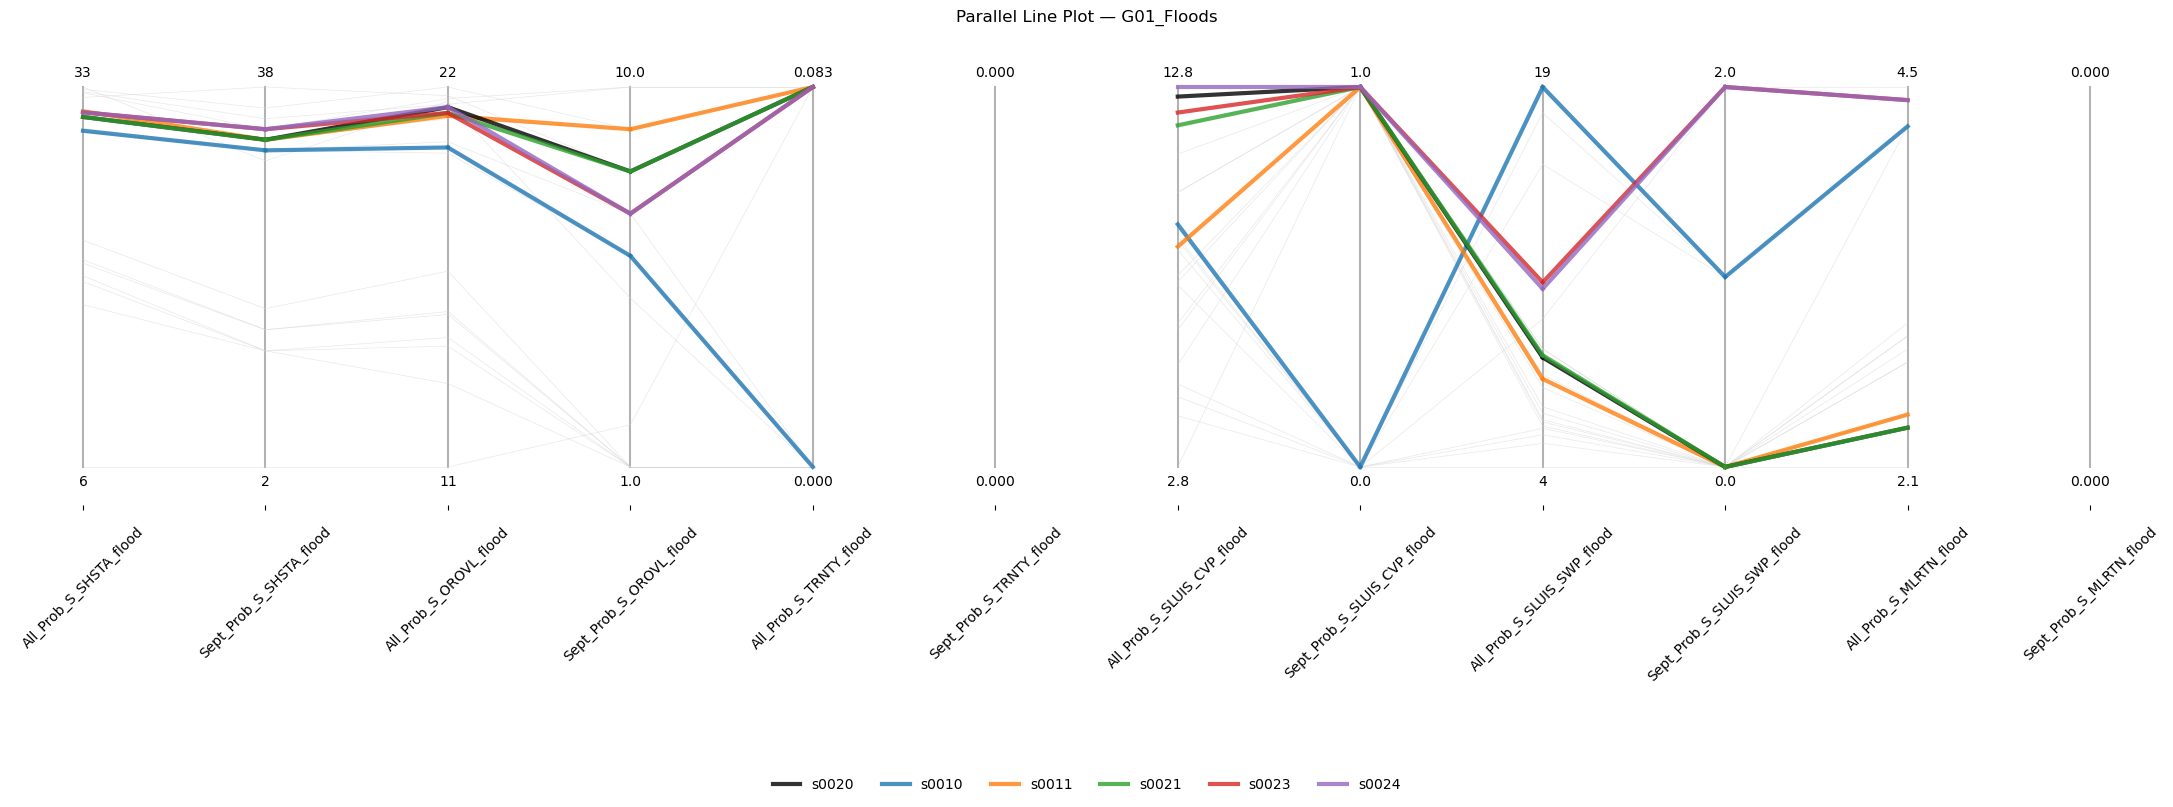

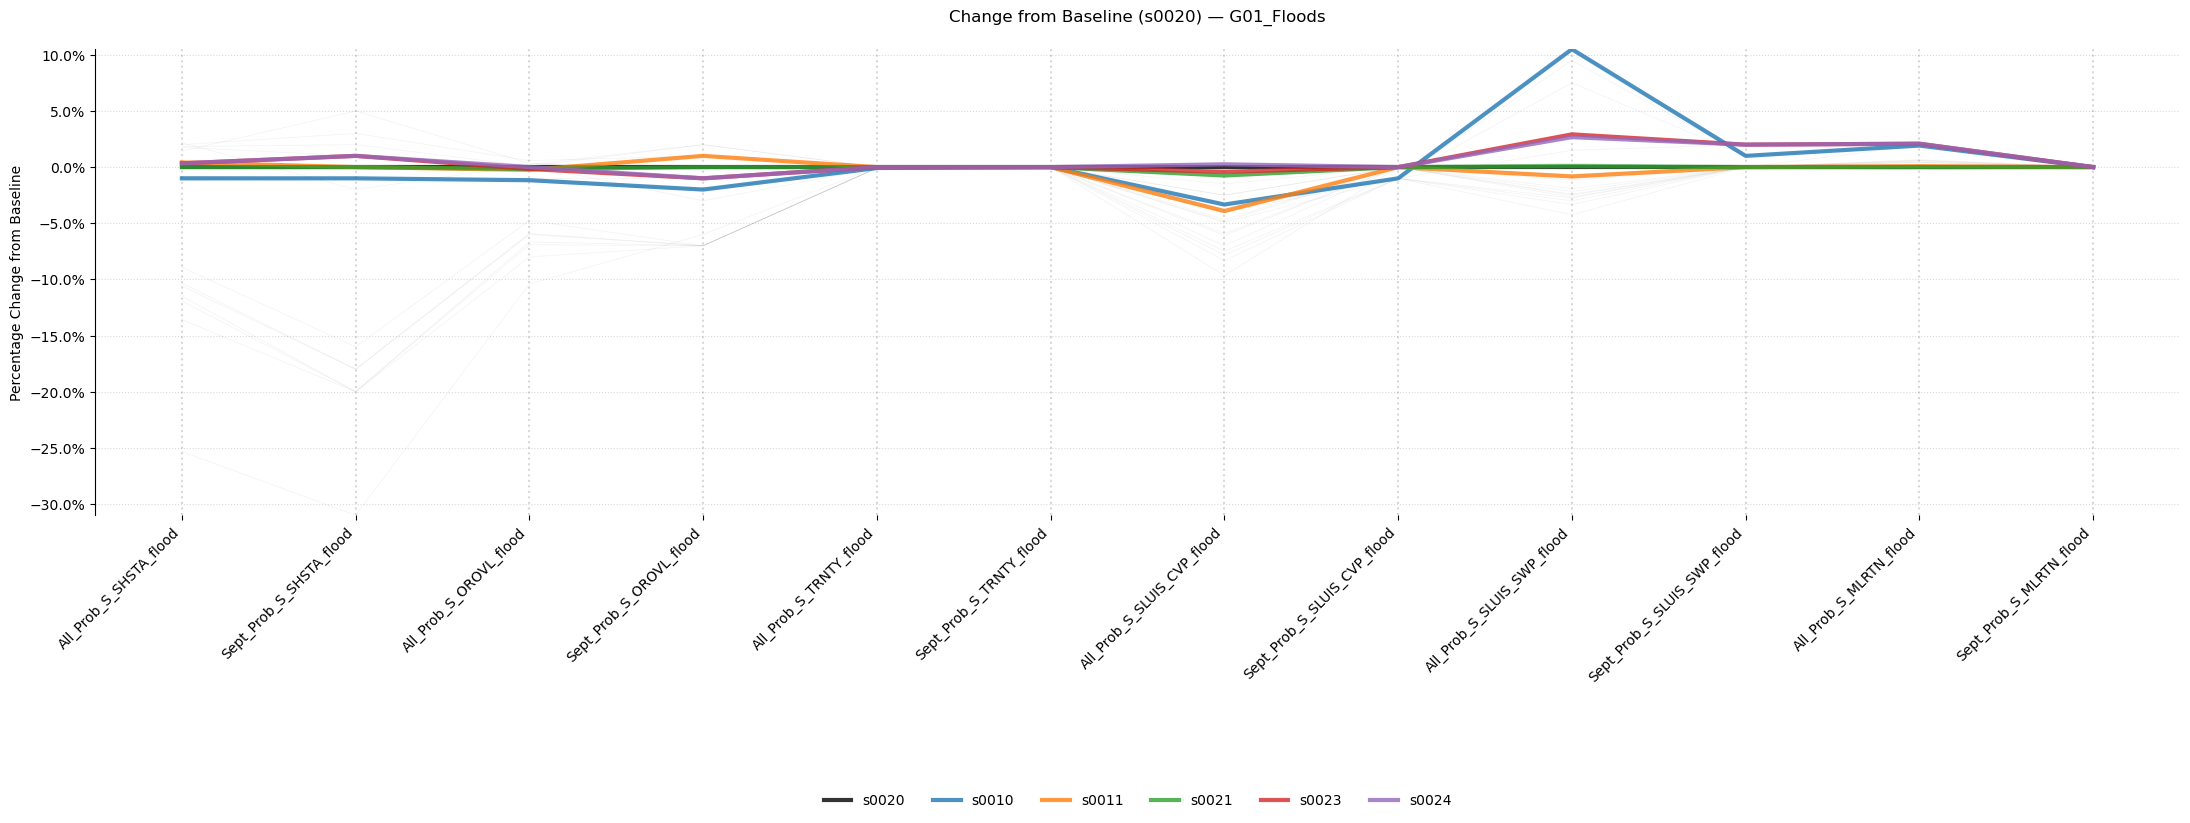

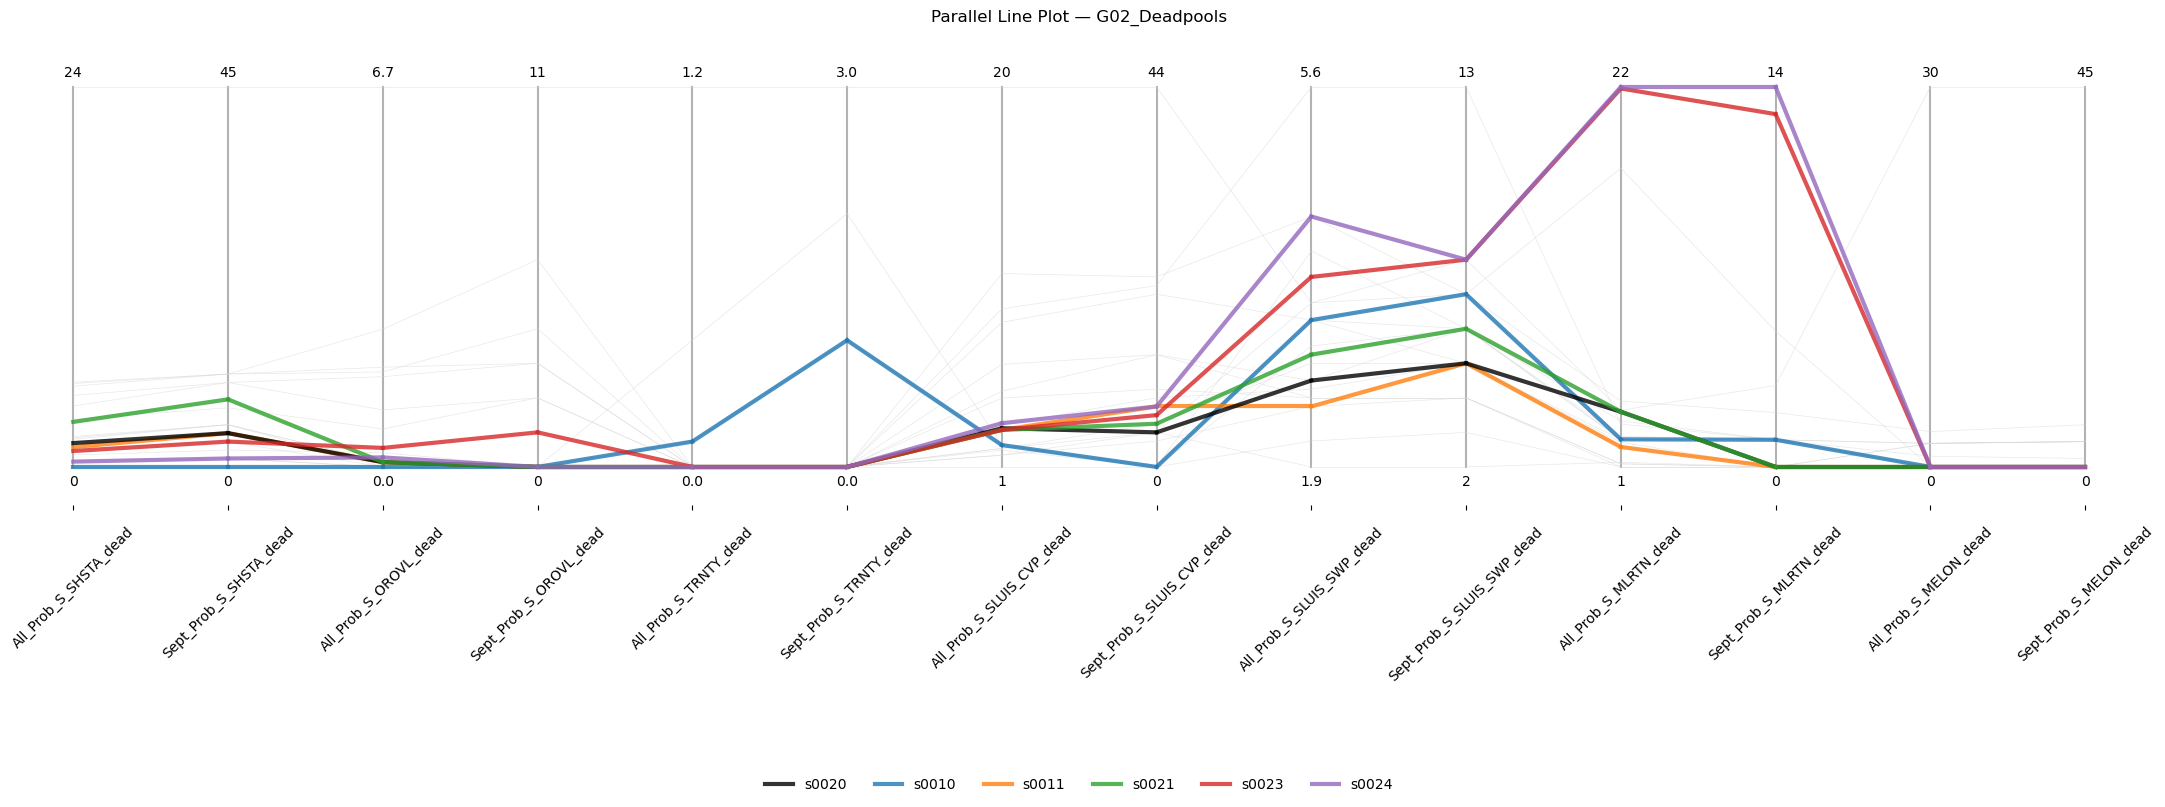

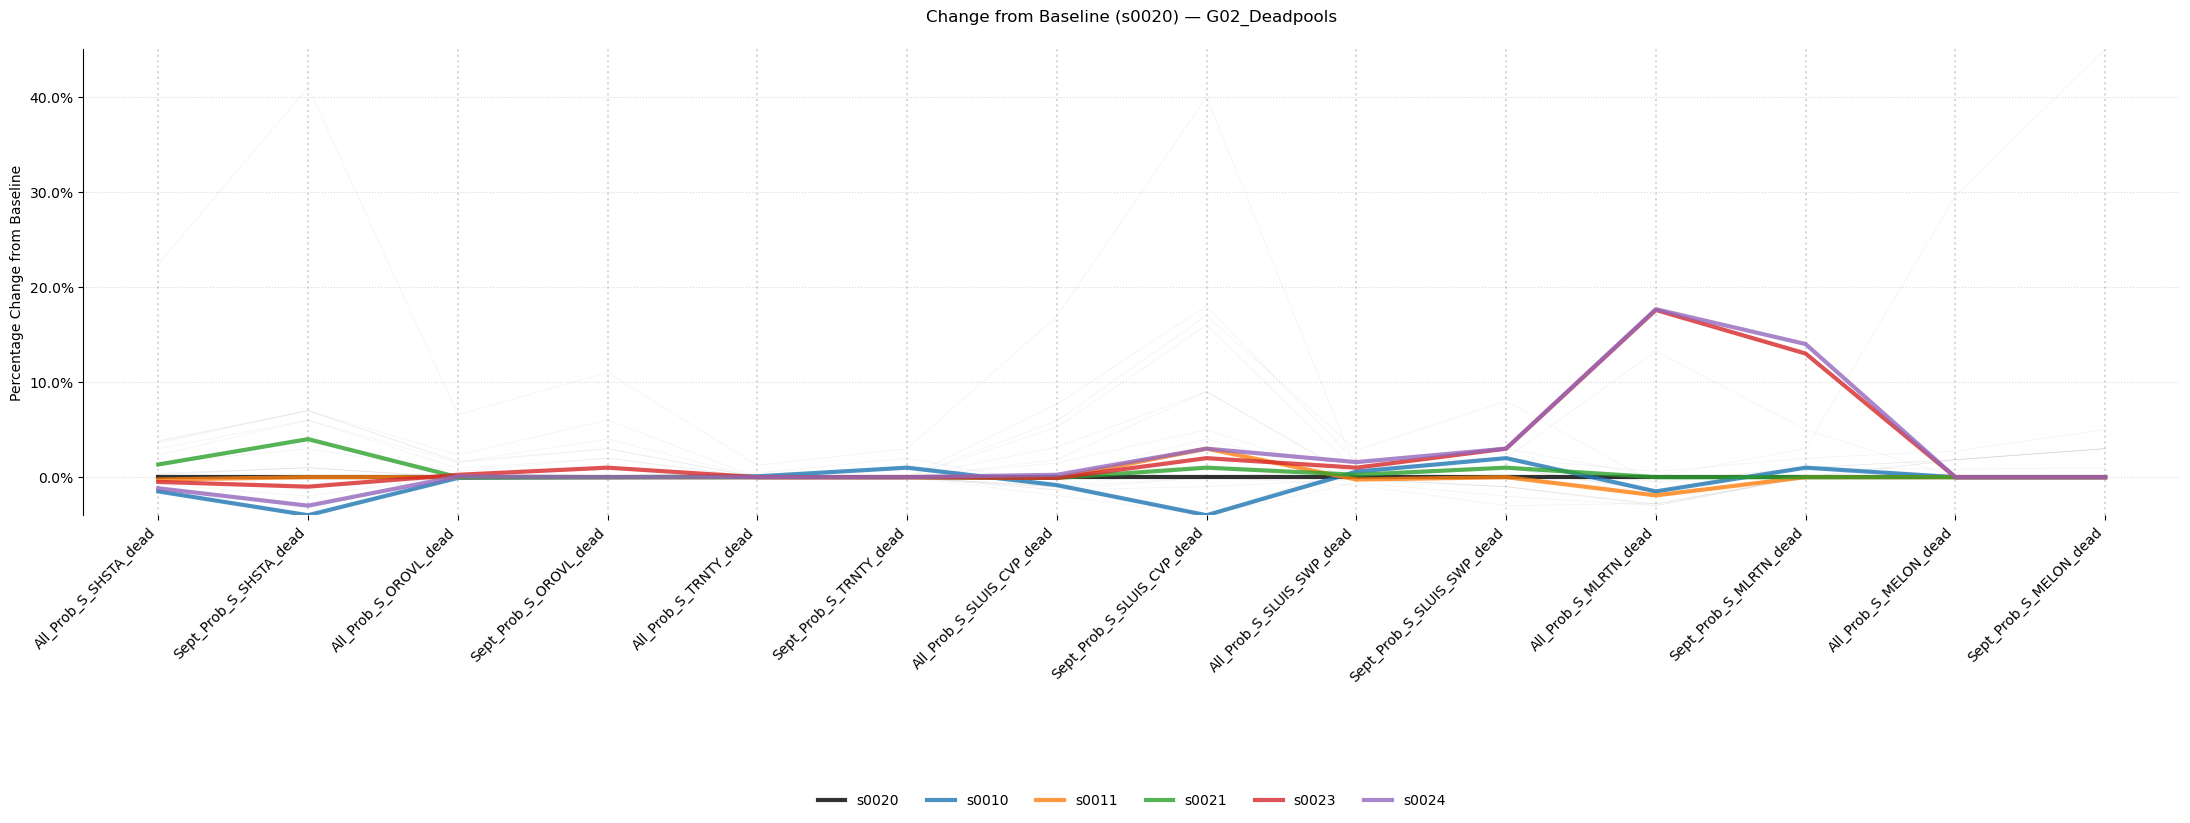

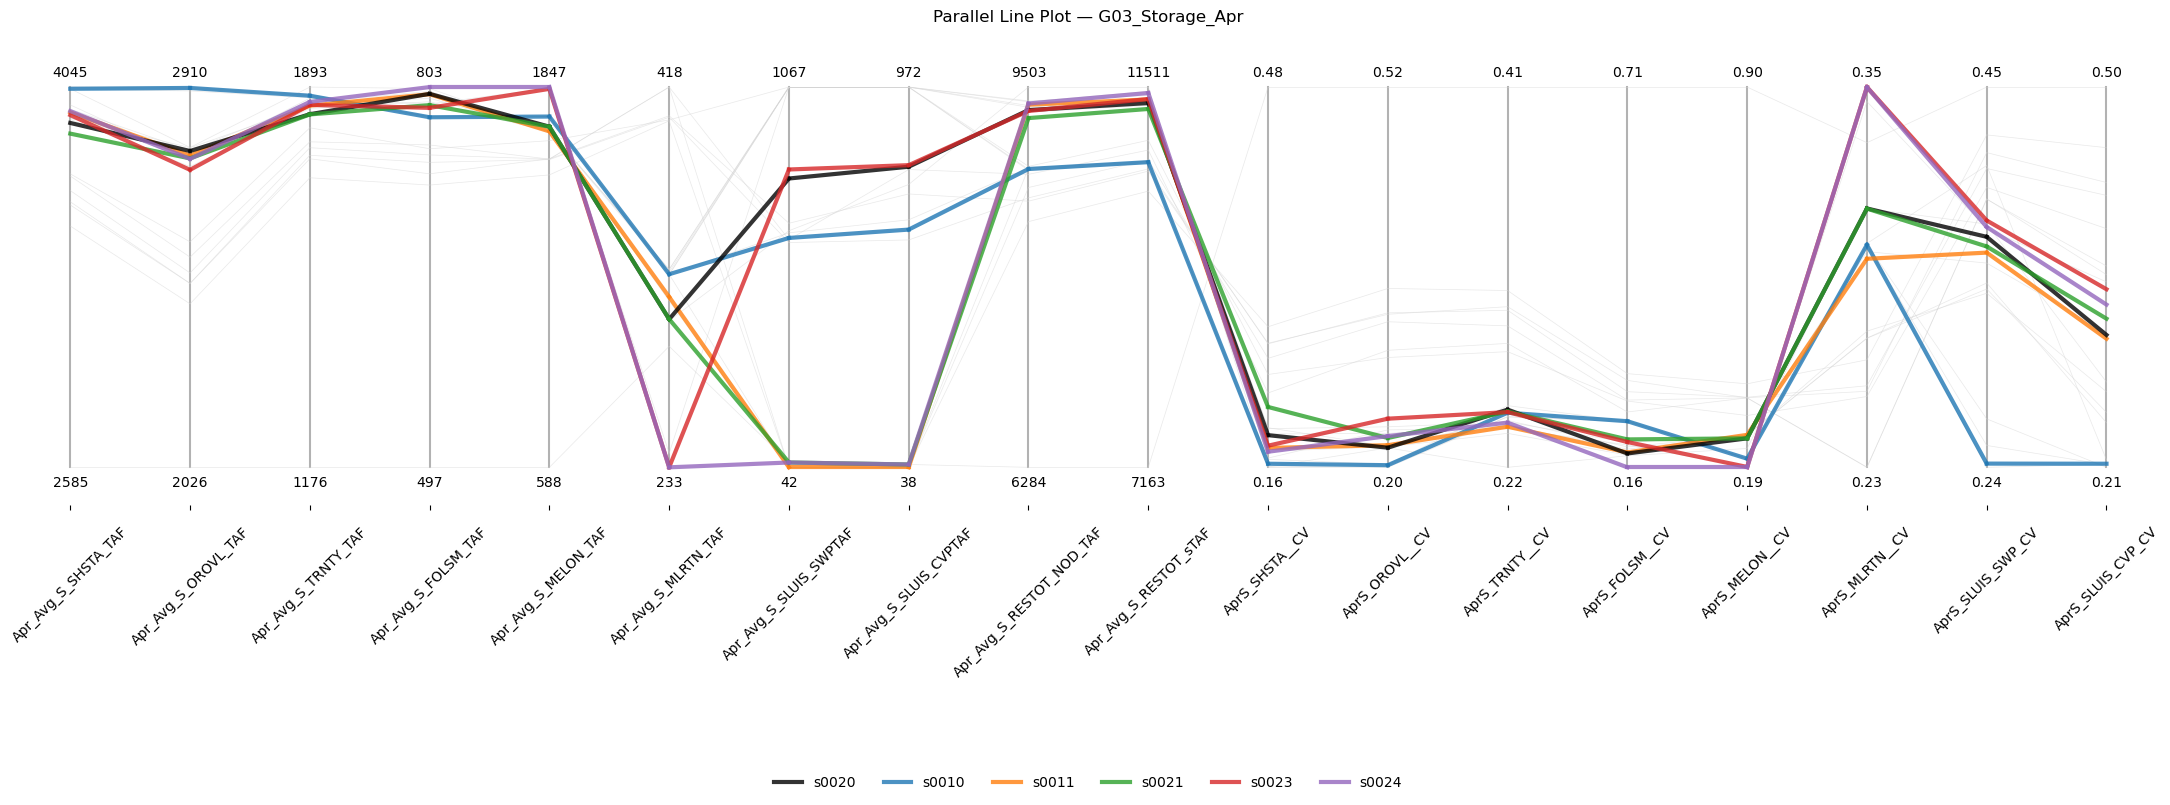

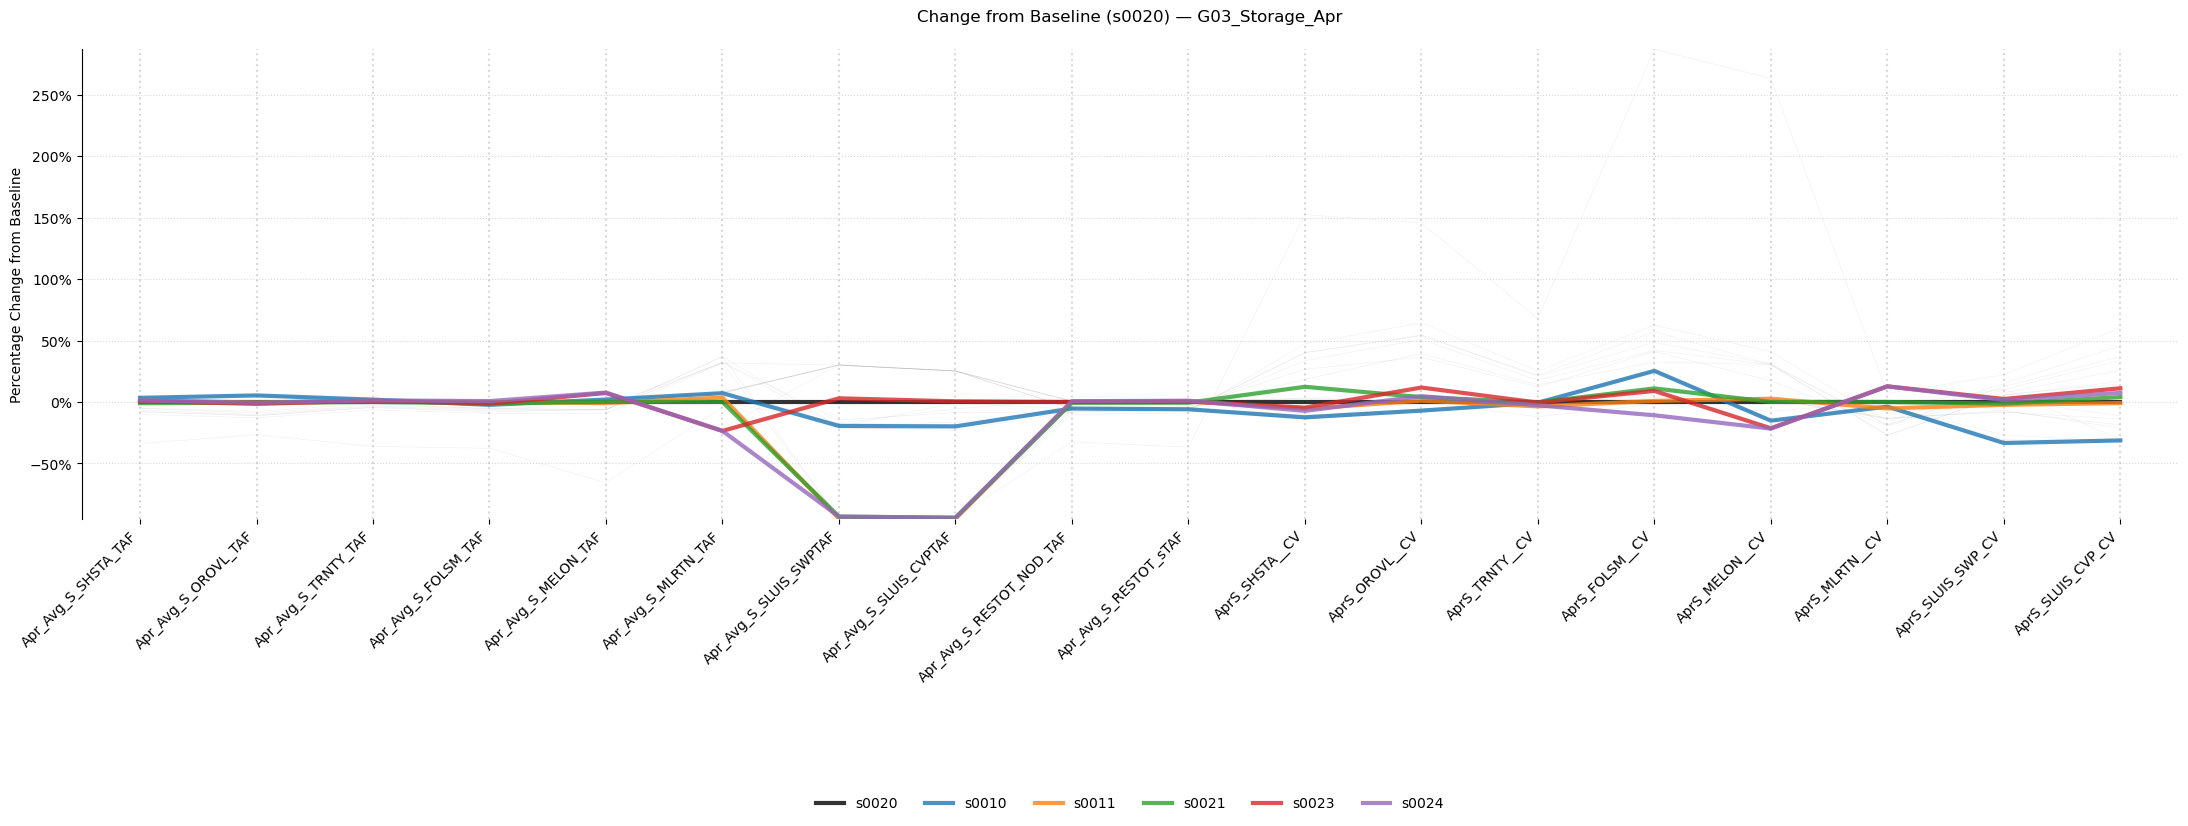

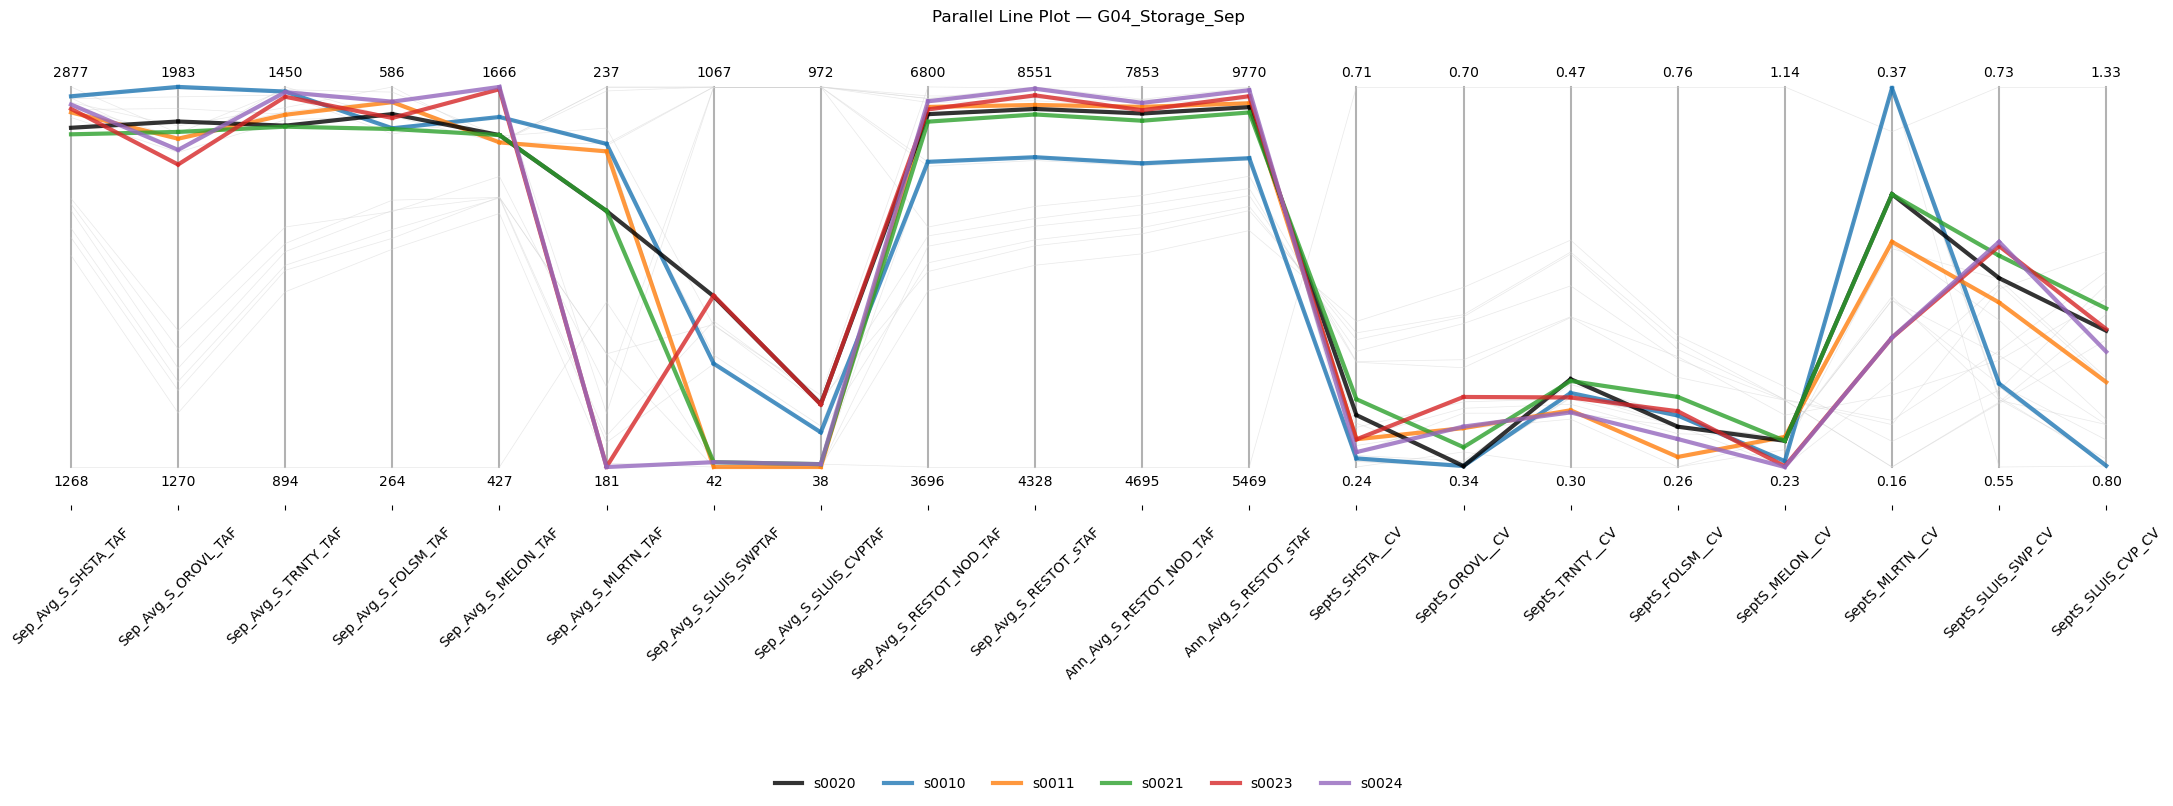

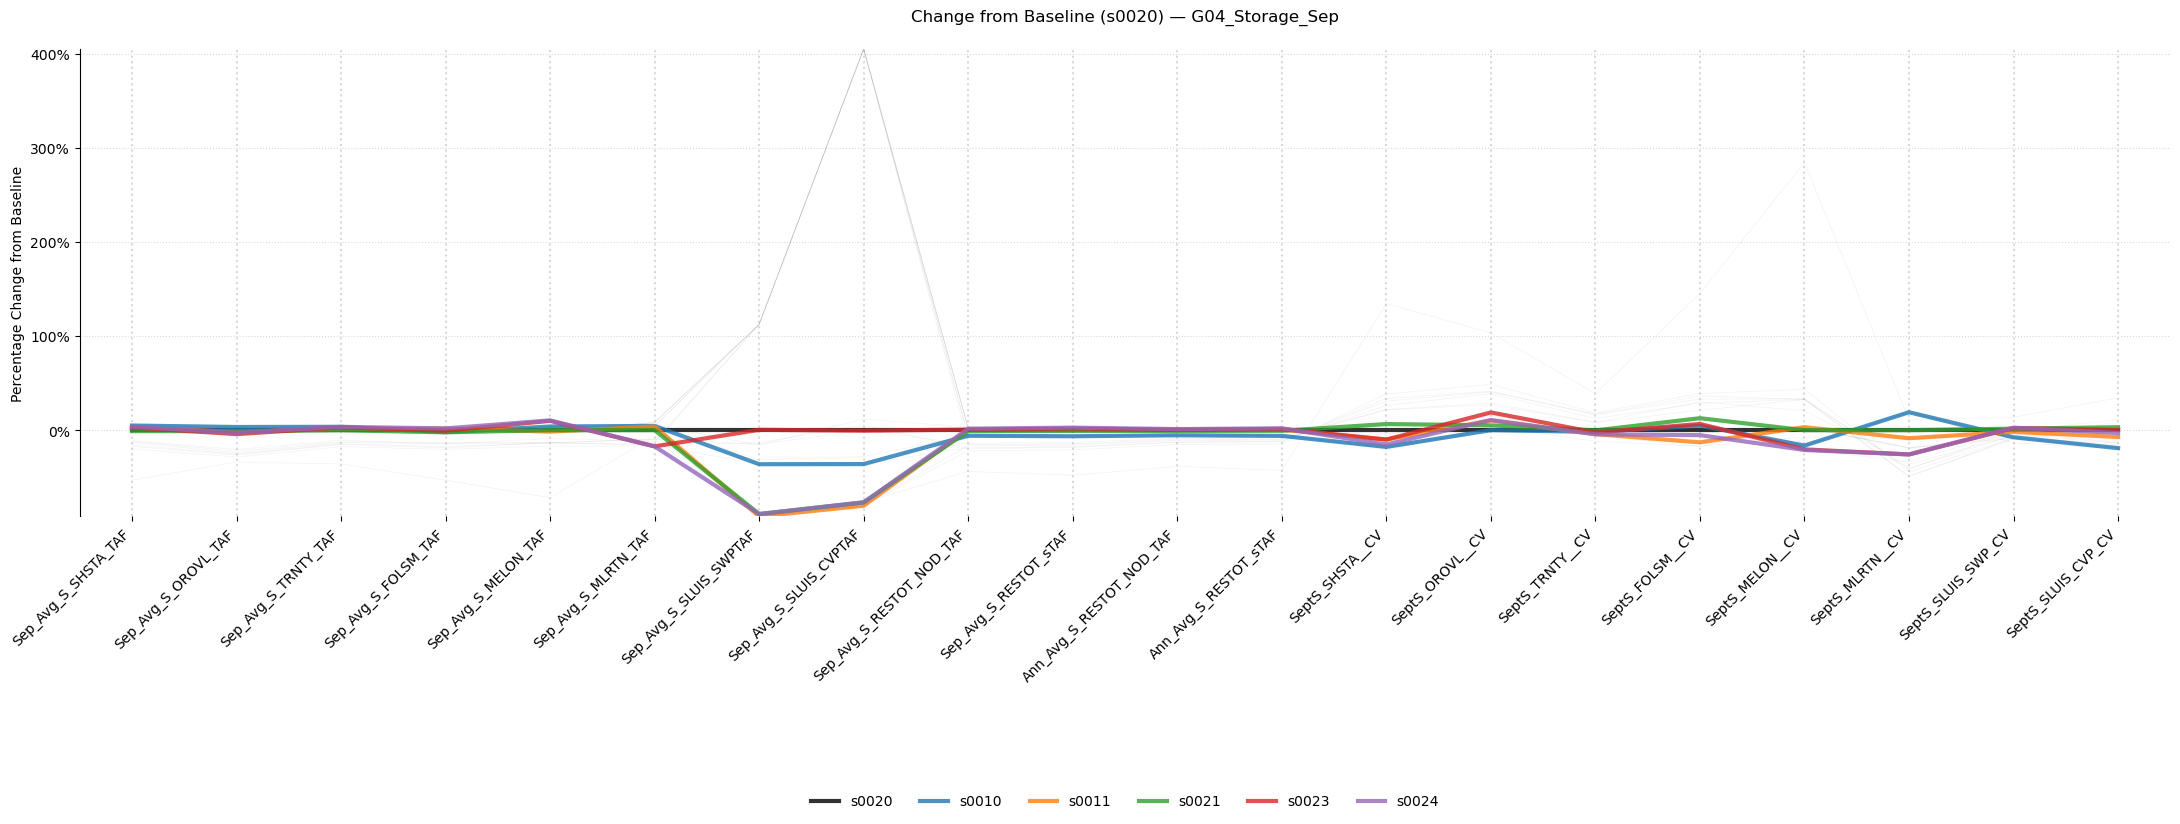

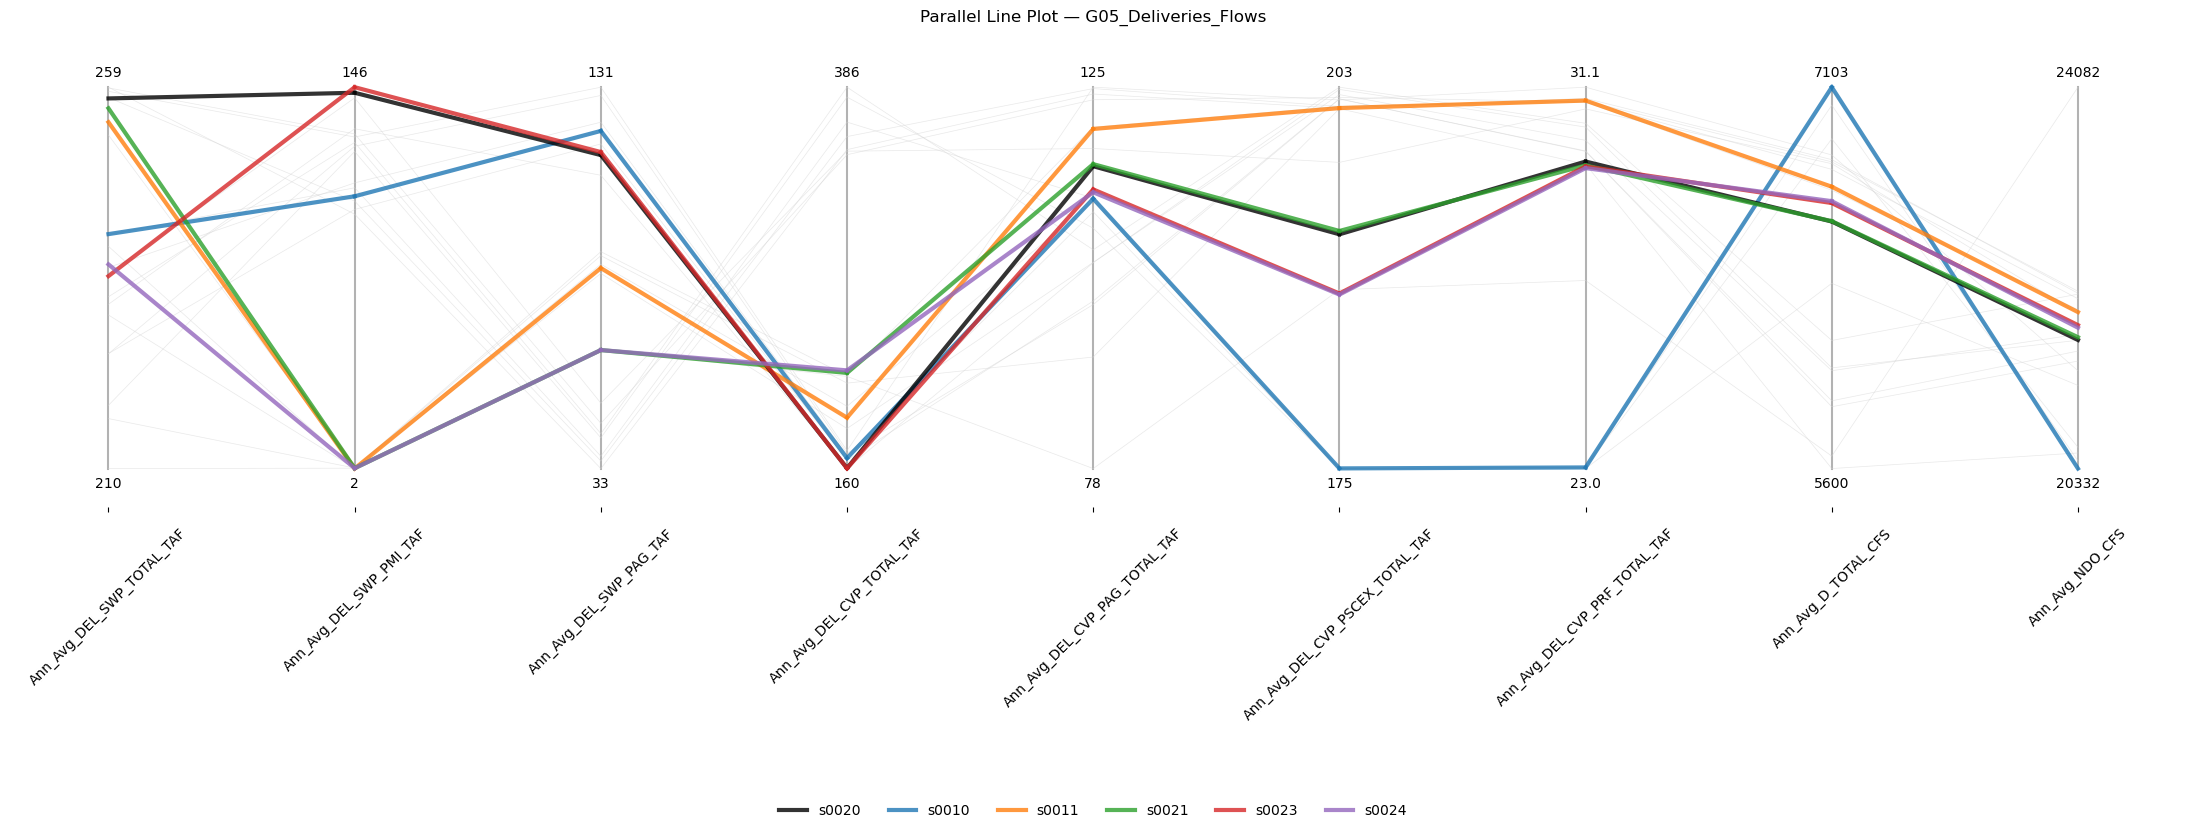

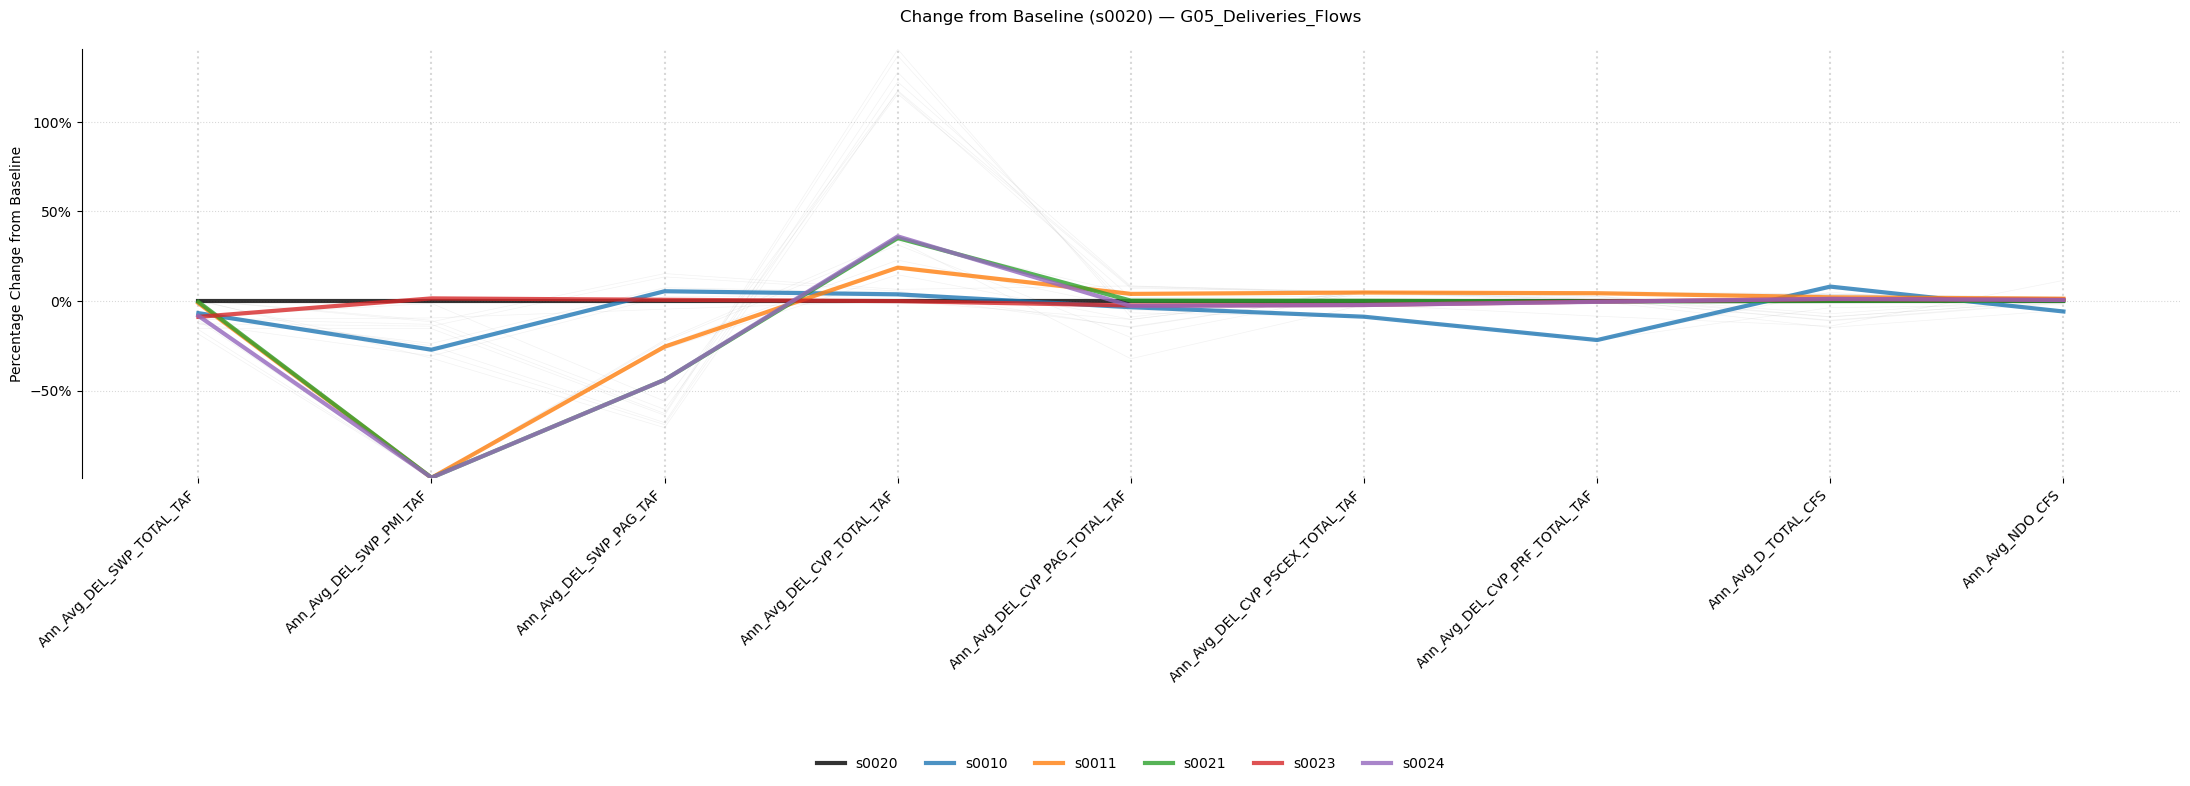

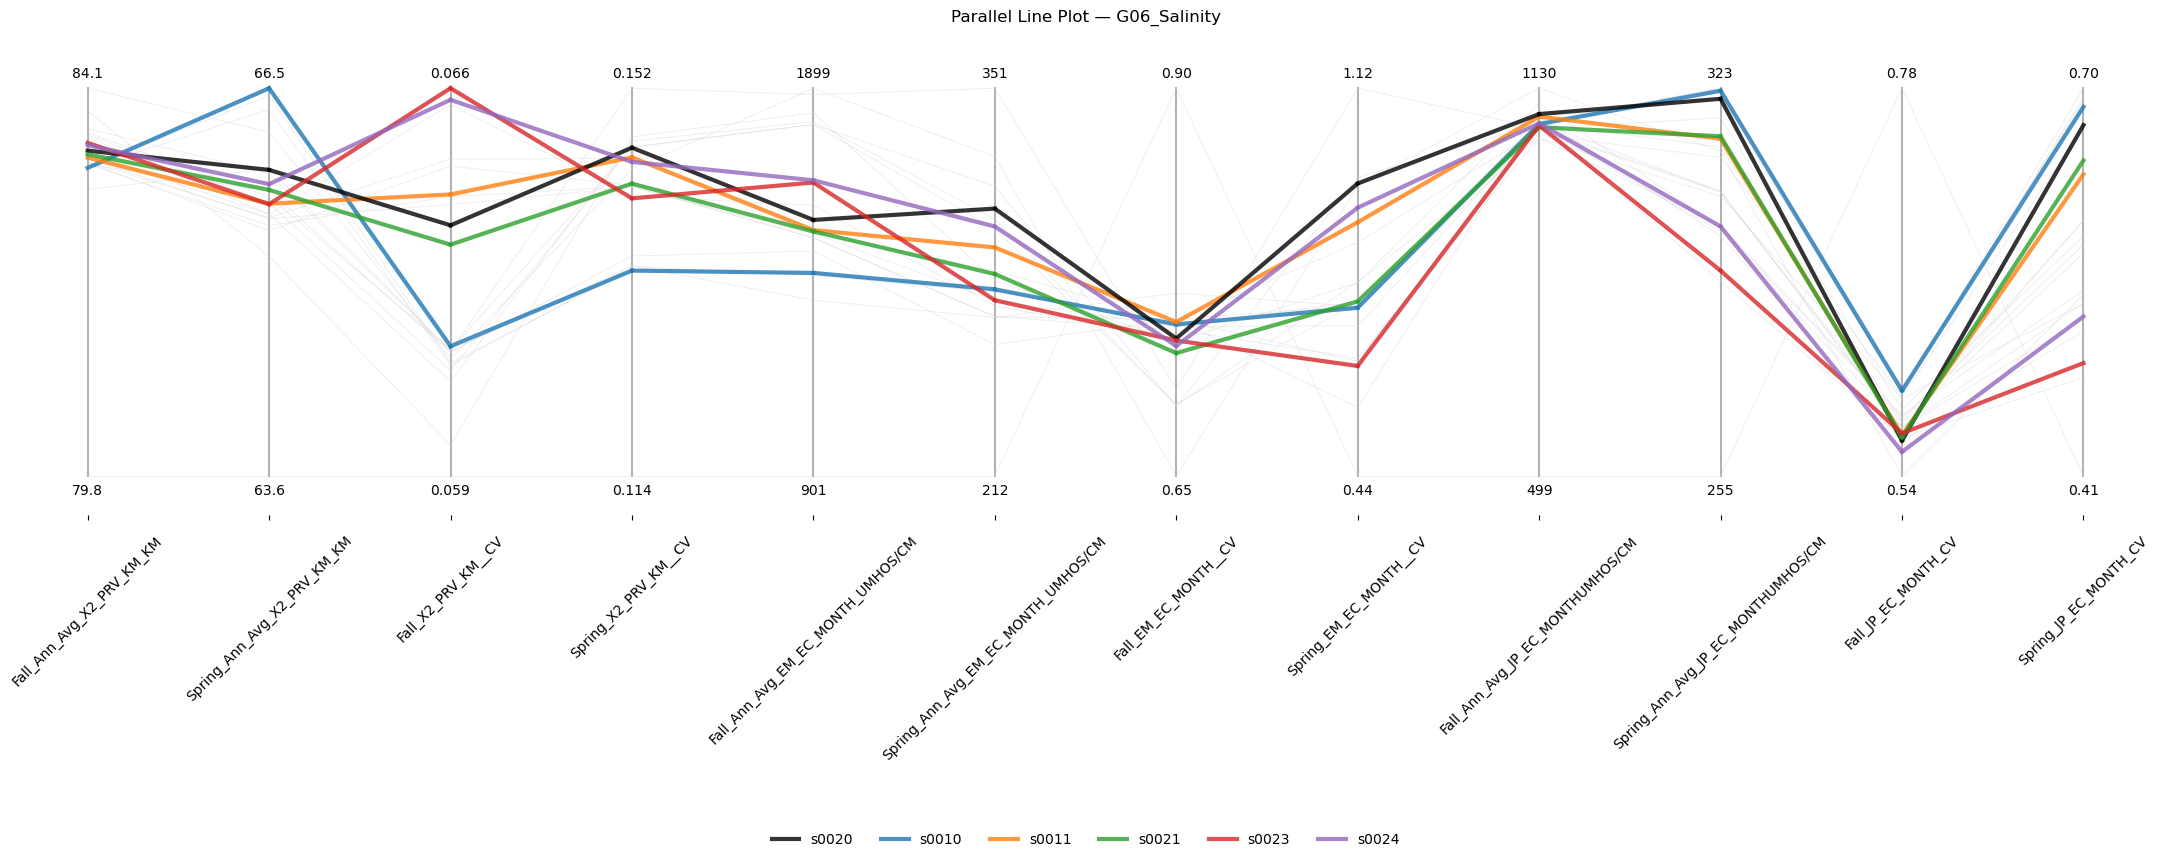

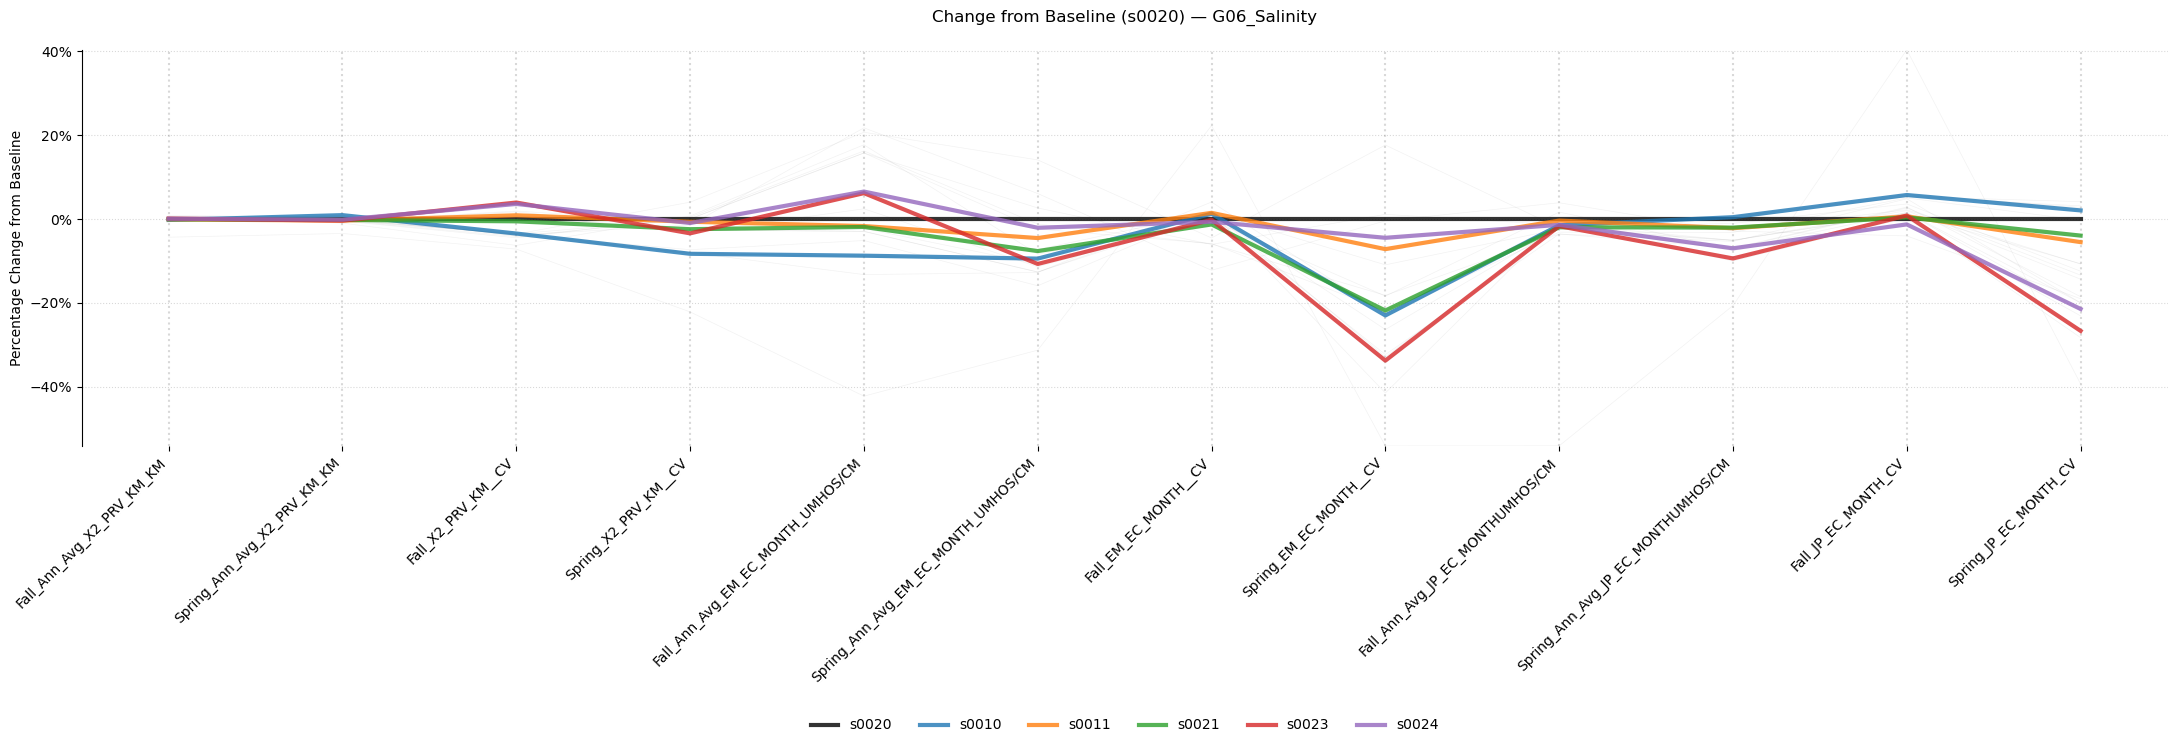

In [31]:
for gname, gcols in GROUPS.items():
    cols = cols_present(combined_df, gcols)
    if not cols:
        print(f"[SKIP] {gname}: no matching columns in combined_df.")
        continue

    out_norm = os.path.join(plots_dir, f"parallel_{gname}.png")
    pu.custom_parallel_coordinates_highlight_scenarios(
        objs=combined_df[cols],
        columns_axes=cols,
        axis_labels=cols,
        ideal_direction='top',
        minmaxs=['max'] * len(cols),
        color_dict_categorical={1: 'grey'},
        highlight_indices=hl_idx,
        highlight_colors=hl_colors,
        highlight_descriptions=hl_labels,
        save_fig_filename=out_norm,
        title=f"Parallel Line Plot — {gname}",
        fontsize=10,
        figsize=(22, 8))

    out_pct = os.path.join(plots_dir, f"parallel_pct_{gname}.png")
    pu.custom_parallel_coordinates_highlight_scenarios_baseline_at_zero(
        objs=combined_df_pct[cols],
        columns_axes=cols,
        axis_labels=cols,
        highlight_indices=hl_idx,
        highlight_colors=hl_colors,
        highlight_descriptions=hl_labels,
        save_fig_filename=out_pct,
        title=f"Change from Baseline ({BASELINE_ID}) — {gname}",
        fontsize=10,
        figsize=(22, 8))

    print(f"Saved: {out_norm}")
    print(f"Saved: {out_pct}")